### Methods and packages 

In [1]:
%run methods_sulfate_deposition.ipynb

/Users/feliciacarlborg/opt/anaconda3/lib/python3.8/site-packages/nbformat/__init__.py:92: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


In [2]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scipy
import warnings 
from tabulate import tabulate
from scipy import interpolate
from scipy import signal
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
import itertools
from tqdm import tqdm
import seaborn as sns
from scipy.stats.stats import pearsonr
import math
from matplotlib.widgets import Slider, RadioButtons

np.set_printoptions(threshold=np.inf)
sns.set_theme(context='paper', style='white', palette='colorblind',font='helvetica')

### All raw data 

In [3]:
%store -r NGRIP_age
%store -r NGRIP_sulfate
%store -r NGRIP_depth
%store -r NGRIP_dO18_age
%store -r NGRIP_dO18_depth
%store -r NGRIP_dO18
%store -r NGRIP_dO18_MCE
%store -r NGRIP_thinning_depth
%store -r NGRIP_thinning
%store -r NGRIP_jiamei_dep
%store -r NGRIP_jiamei_age
%store -r JL_NGRIP_age_start
%store -r JL_NGRIP_age_middle
%store -r JL_NGRIP_age_end
%store -r JL_NGRIP_s
%store -r depth_bp_NGRIP
%store -r depths_lost_NGRIP

### Annual thinning 

In [4]:
NGRIP_annual = np.arange(10212,108004, 1)
NGRIP_depth_annual = np.interp(NGRIP_annual, NGRIP_age, NGRIP_depth)
NGRIP_depth_annual_top = np.interp(NGRIP_annual, NGRIP_age[:-1], NGRIP_depth[:-1])
NGRIP_depth_annual_bottom = np.interp(NGRIP_annual, NGRIP_age[1:], NGRIP_depth[1:])
NGRIP_depth_annual_th = (NGRIP_depth_annual[1:] + NGRIP_depth_annual[:-1])/2
NGRIP_thinning_depth = np.array(NGRIP_thinning_depth, dtype='float64')
NGRIP_thinning = np.array(NGRIP_thinning, dtype='float64')
NGRIP_annual_thinning = np.interp(NGRIP_depth_annual_th, NGRIP_thinning_depth, NGRIP_thinning)

## Accumulation rate

In [5]:
sheet6 = pd.ExcelFile('AICC2012_official.xls')
thinning = pd.read_excel(sheet6, 'NGRIP')
thinning = np.array(thinning)
NGRIP_acc_depth = np.array(thinning[1:,0], dtype='float64')
NGRIP_acc = np.array(thinning[1:,5], dtype='float64')

NGRIP_acc_depth_corr = np.interp(NGRIP_depth_annual,NGRIP_acc_depth, NGRIP_acc)


(0.0411842751999989, 0.18277871199999565, 0.08904073467868587)

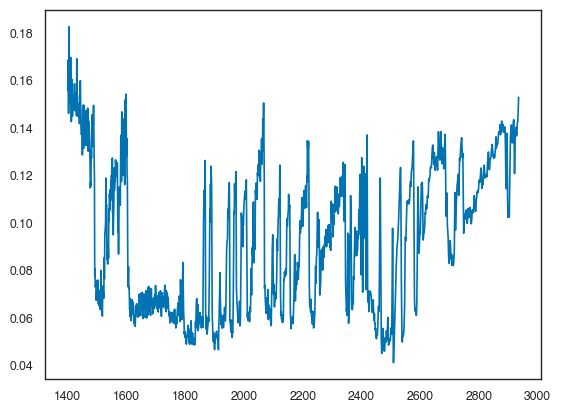

In [6]:
NGRIP_min_acc = np.nanmin(NGRIP_acc_depth_corr)
NGRIP_max_acc = np.nanmax(NGRIP_acc_depth_corr)
NGRIP_mean_acc = np.nanmean(NGRIP_acc_depth_corr)

plt.figure()
plt.plot(NGRIP_depth_annual, NGRIP_acc_depth_corr)

NGRIP_min_acc, NGRIP_max_acc, NGRIP_mean_acc

In [7]:
NGRIP_depth_annual_top[500], NGRIP_depth_annual_bottom[500]

(1434.3039999999999, 1434.3039999999999)

### Annual thickness ### 

In [8]:
NGRIP_annual_thickness = NGRIP_depth_annual_top - NGRIP_depth_annual_bottom

%store NGRIP_annual_thickness

Stored 'NGRIP_annual_thickness' (ndarray)


### Annual sulfate

In [9]:
NGRIP_sulfate_annual = annual_average(NGRIP_annual, NGRIP_age, NGRIP_sulfate)


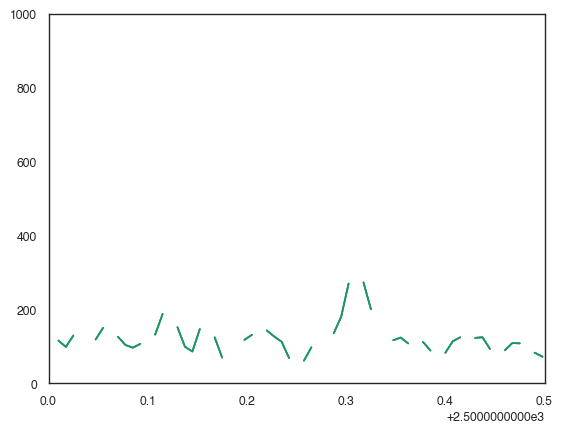

In [10]:
plt.figure()
plt.plot(NGRIP_depth_annual, NGRIP_sulfate_annual)
plt.plot(NGRIP_depth_annual_bottom, NGRIP_sulfate_annual)
plt.plot(NGRIP_depth_annual_top, NGRIP_sulfate_annual)
plt.xlim(2500,2500.5)
plt.ylim(0,1000)
plt.show()

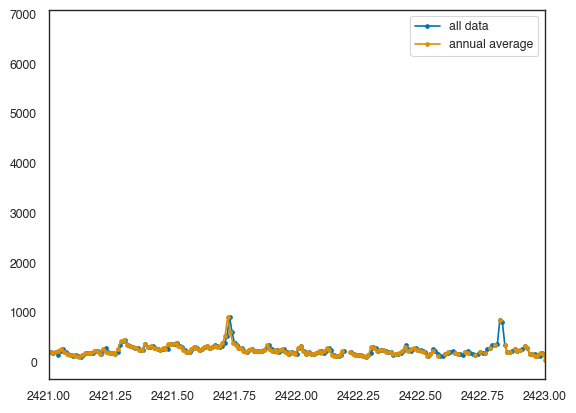

In [11]:
plt.figure()
plt.plot(NGRIP_depth, NGRIP_sulfate, '.-', label='all data')
plt.plot(NGRIP_depth_annual, NGRIP_sulfate_annual, '.-', label = 'annual average')
plt.legend()
plt.xlim(2421,2423)
plt.show()

-32.11


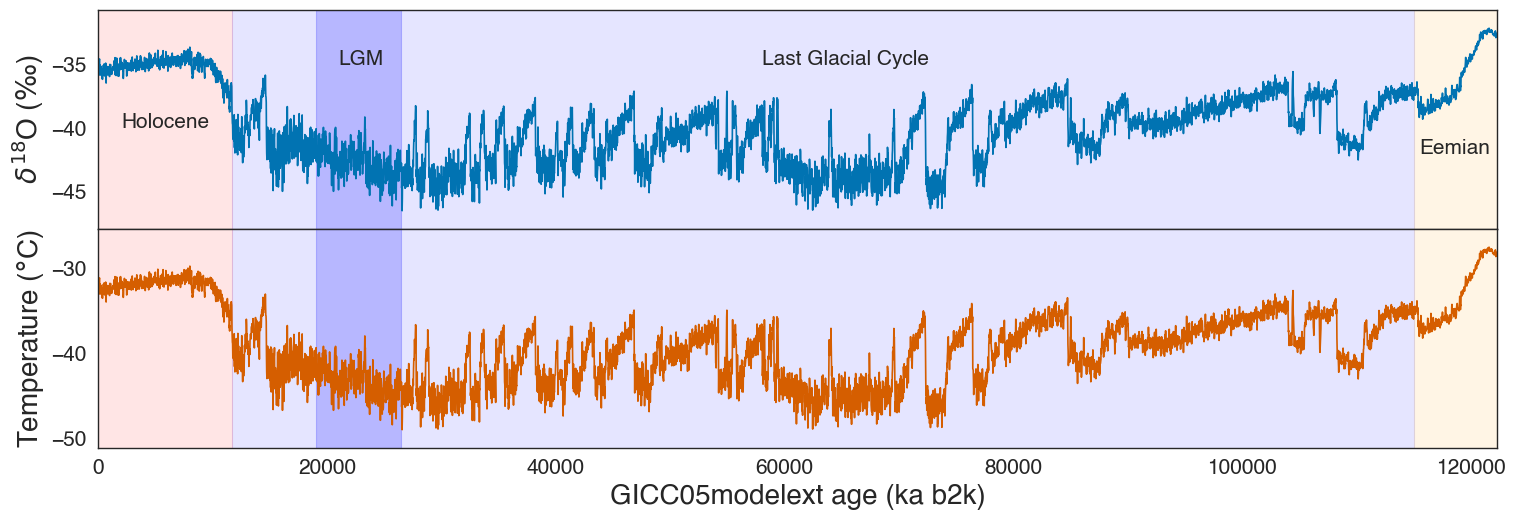

In [12]:
%matplotlib inline

NGRIP_dO18_age = np.array(NGRIP_dO18_age,dtype='float64')
NGRIP_dO18 = np.array(NGRIP_dO18, dtype='float64')

def age_interp(age):
    return np.arange(math.floor(age[~np.isnan(age)][0]), math.ceil(age[~np.isnan(age)][-1]),1)

NGRIP_annual_d18O = age_interp(NGRIP_dO18_age)

#print(GISP2_annual[0], GISP2_d18O_age[~np.isnan(GISP2_d18O_age)][0], GISP2_annual[-1], GISP2_d18O_age[~np.isnan(GISP2_d18O_age)][-1])

NGRIP_annual_d18O = annual_average(NGRIP_annual_d18O, NGRIP_dO18_age[~np.isnan(NGRIP_dO18_age)], NGRIP_dO18[~np.isnan(NGRIP_dO18_age)])

def temperature(d180):
    return (d180 + 13.7)/0.67

NGRIP_temp = temperature(NGRIP_dO18)
size=20
ticksize=15
era_size = 15

print(np.nanmax(NGRIP_dO18))

fig, ax = plt.subplots(2,figsize=(15,5), sharex=True)
ax[0].plot(NGRIP_dO18_age, NGRIP_dO18, c='b')
ax[0].set_ylabel(r'$\delta^{18}$O ($‰$)', fontsize=size)
ax[1].plot(NGRIP_dO18_age, NGRIP_temp, c = 'r')
ax[1].set_ylabel(r'Temperature ($\degree$C)', fontsize=size)
ax[1].set_xlabel('GICC05modelext age (ka b2k)', fontsize=size)
ax[0].margins(x=0.0, y=0.1) # 10% padding in the y-direction only
ax[1].margins(x=0.0, y=0.1)
ax[0].tick_params(axis='both', labelsize=ticksize)
ax[1].tick_params(axis='both', labelsize=ticksize)
ax[0].axvspan(0, 11.7*1e3, alpha=0.1, color='red')
ax[0].axvspan(11.7*1e3, 115*1e3, alpha=0.1, color='blue')
ax[1].axvspan(11.7*1e3, 115*1e3, alpha=0.1, color='blue')
ax[0].axvspan(115*1e3, np.nanmax(NGRIP_dO18_age), alpha=0.1, color='orange')
ax[1].axvspan(115*1e3, np.nanmax(NGRIP_dO18_age), alpha=0.1, color='orange')
ax[1].axvspan(0, 11.7*1e3, alpha=0.1, color='red')
ax[0].axvspan(19*1e3, 26.5*1e3, alpha=0.2, color='blue')
ax[1].axvspan(19*1e3, 26.5*1e3, alpha=0.2, color='blue')
ax[0].text(2*1e3, -40, 'Holocene', fontsize=era_size)
ax[0].text(58*1e3, -35, 'Last Glacial Cycle', fontsize=era_size)
ax[0].text(115.5*1e3, -42, 'Eemian', fontsize=era_size)
#ax[1].text(115.5*1e3, -42, 'Eemian', fontsize=era_size)
#ax[1].text(58*1e3, -33, 'Last Glacial Cycle', fontsize=era_size)
#ax[1].text(2*1e3, -40, 'Holocene', fontsize=era_size)
ax[0].text(21*1e3, -35, 'LGM', fontsize=era_size)
#ax[1].text(21*1e3, -33, 'LGM', fontsize=era_size)
fig.tight_layout(pad=0)
plt.savefig('NGRIP_d18O_temperature', dpi=1000, bbox_inches='tight')
plt.show()

### Arrays to find sulfate deposition 

In [13]:
NGRIP_age_list = np.arange(10*1e3,110*1e3,2000) #list with ages for the different intervals

In [14]:
NGRIP_filt =51 #running median filter NGRIP
NGRIP_exl_volc = exl_volcanism(NGRIP_annual, NGRIP_sulfate_annual,NGRIP_filt,z=3)
NGRIP_RM = running_median(NGRIP_annual, NGRIP_sulfate_annual, NGRIP_filt)
NGRIP_RRM = running_median(NGRIP_annual, NGRIP_exl_volc, NGRIP_filt)
NGRIP_RMAD = median_of_absolute_deviation(NGRIP_annual,  NGRIP_exl_volc, NGRIP_filt, z=3)

In [15]:
thresholds = np.arange(.5,4.5,.5)

all_RMAD_NGRIP = pd.DataFrame()
all_RRM_NGRIP = pd.DataFrame()

for i in range(len(thresholds)):
    NGRIP_exl_volc_test = exl_volcanism(NGRIP_annual, NGRIP_sulfate_annual,NGRIP_filt,thresholds[i])
    NGRIP_RRM_test = running_median(NGRIP_annual, NGRIP_exl_volc_test, NGRIP_filt)
    NGRIP_RMAD_test = median_of_absolute_deviation(NGRIP_annual,  NGRIP_exl_volc_test, NGRIP_filt, thresholds[i])
    all_RRM_NGRIP[i] = NGRIP_RRM_test
    all_RMAD_NGRIP[i] = NGRIP_RMAD_test
    

In [16]:
all_RRM_NGRIP = np.array(all_RRM_NGRIP)
all_RMAD_NGRIP = np.array(all_RMAD_NGRIP)

%store all_RMAD_NGRIP
%store all_RRM_NGRIP

Stored 'all_RMAD_NGRIP' (ndarray)
Stored 'all_RRM_NGRIP' (ndarray)


In [17]:
corr = pearsonr(all_RMAD_NGRIP[:,5], NGRIP_RMAD)

corr

(1.0, 0.0)

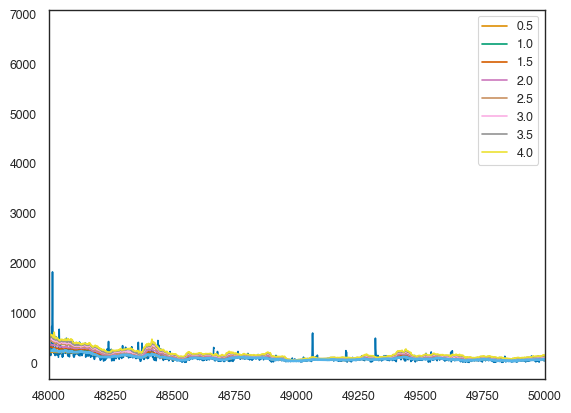

In [18]:
%matplotlib inline
plt.figure()
plt.plot(NGRIP_annual, NGRIP_sulfate_annual)
for i in range(len(thresholds)):
    plt.plot(NGRIP_annual, all_RMAD_NGRIP[:,i], label= str(thresholds[i]))
plt.plot(NGRIP_annual, NGRIP_RRM, linewidth=2)
plt.xlim(48000,50000)
plt.legend()
plt.show()

In [19]:
len(NGRIP_RRM), len(NGRIP_annual), len(NGRIP_RMAD), len(NGRIP_sulfate_annual)

(97792, 97792, 97792, 97792)

In [20]:
%store NGRIP_RRM
%store NGRIP_RMAD
%store NGRIP_sulfate_annual
%store NGRIP_annual
%store NGRIP_depth_annual
%store NGRIP_depth_annual_th
%store NGRIP_annual_thickness
%store NGRIP_annual_thinning
%store NGRIP_depth_annual_top
%store NGRIP_depth_annual_bottom

Stored 'NGRIP_RRM' (ndarray)
Stored 'NGRIP_RMAD' (ndarray)
Stored 'NGRIP_sulfate_annual' (ndarray)
Stored 'NGRIP_annual' (ndarray)
Stored 'NGRIP_depth_annual' (ndarray)
Stored 'NGRIP_depth_annual_th' (ndarray)
Stored 'NGRIP_annual_thickness' (ndarray)
Stored 'NGRIP_annual_thinning' (ndarray)
Stored 'NGRIP_depth_annual_top' (ndarray)
Stored 'NGRIP_depth_annual_bottom' (ndarray)


In [21]:
depths_lost_NGRIP = np.array(depths_lost_NGRIP)
age_lost_NGRIP = np.interp(depths_lost_NGRIP, NGRIP_depth_annual, NGRIP_annual)

age_lost_NGRIP

array([], dtype=float64)

### 2k intervals with d18O and sulfate data 

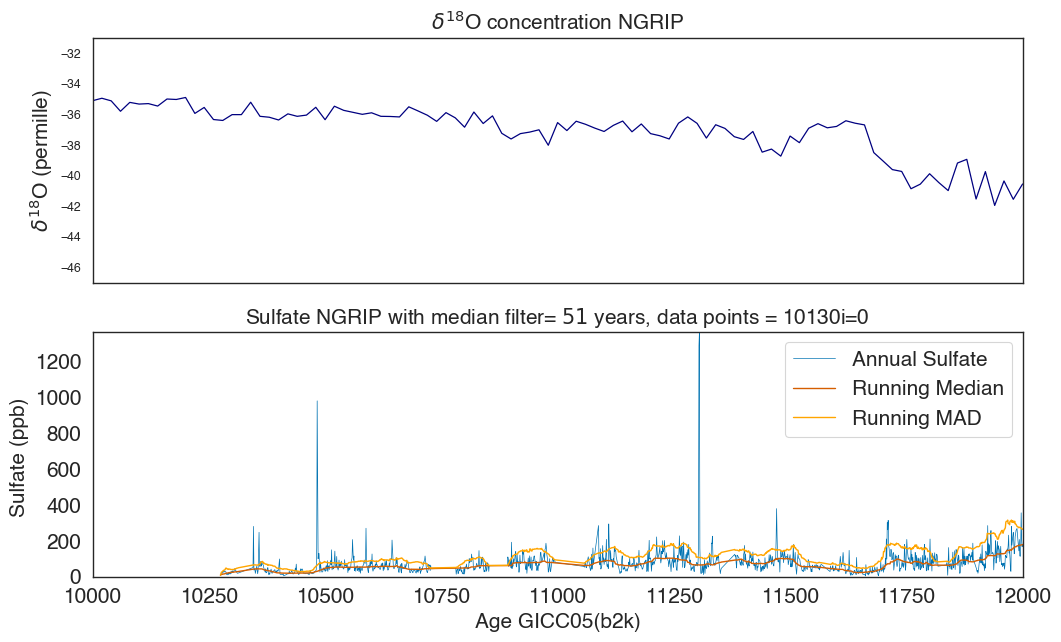

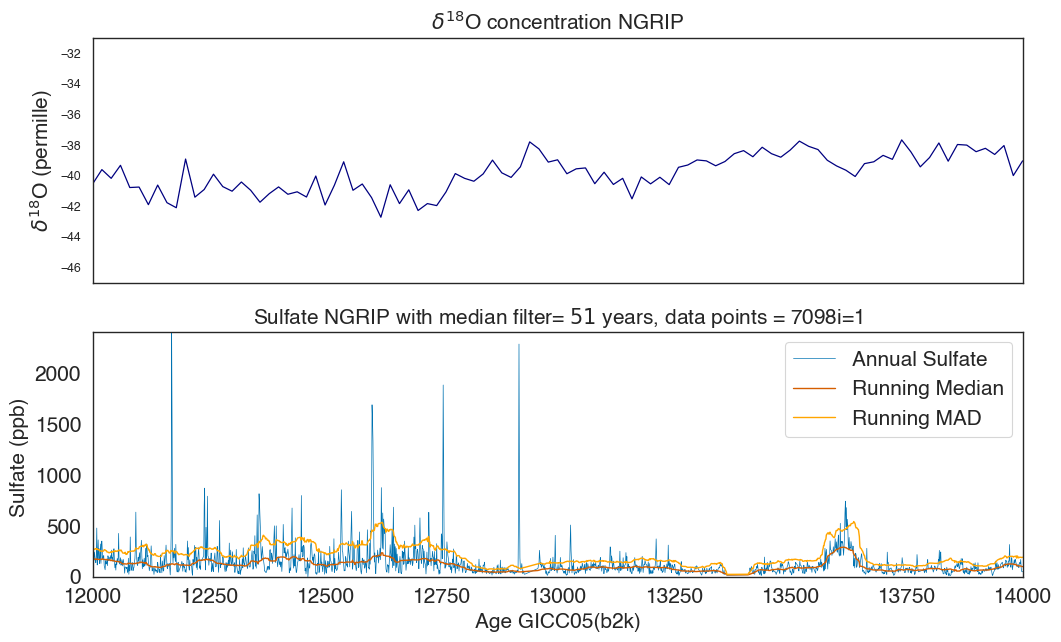

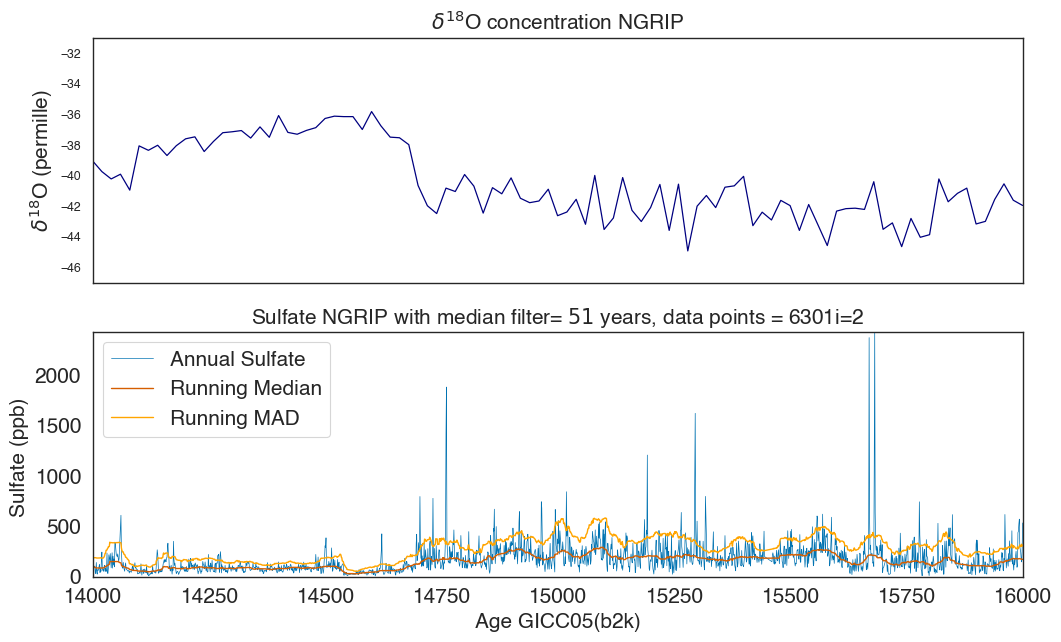

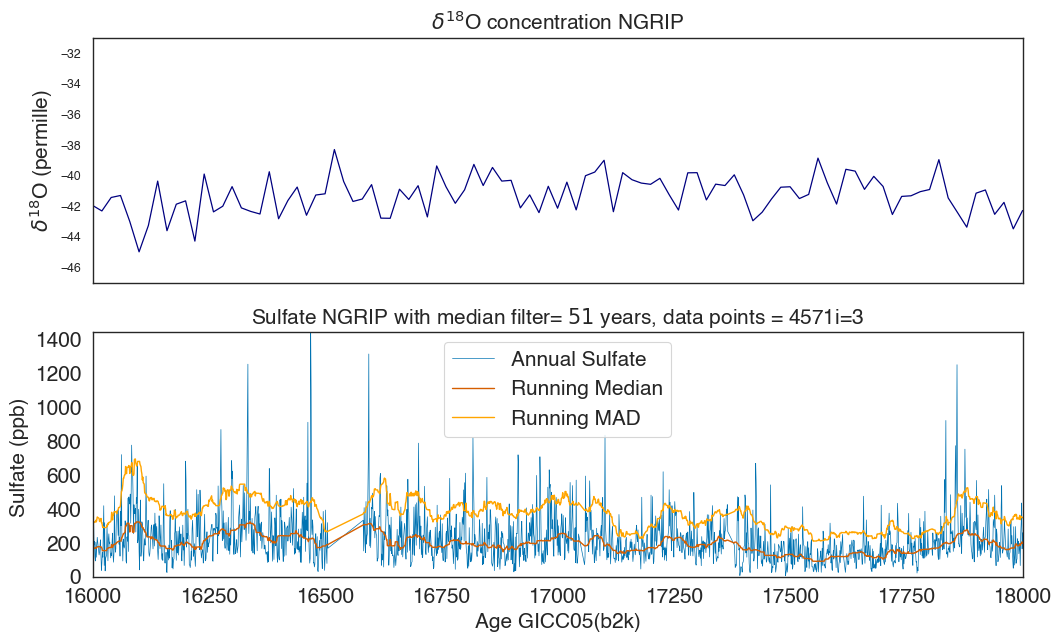

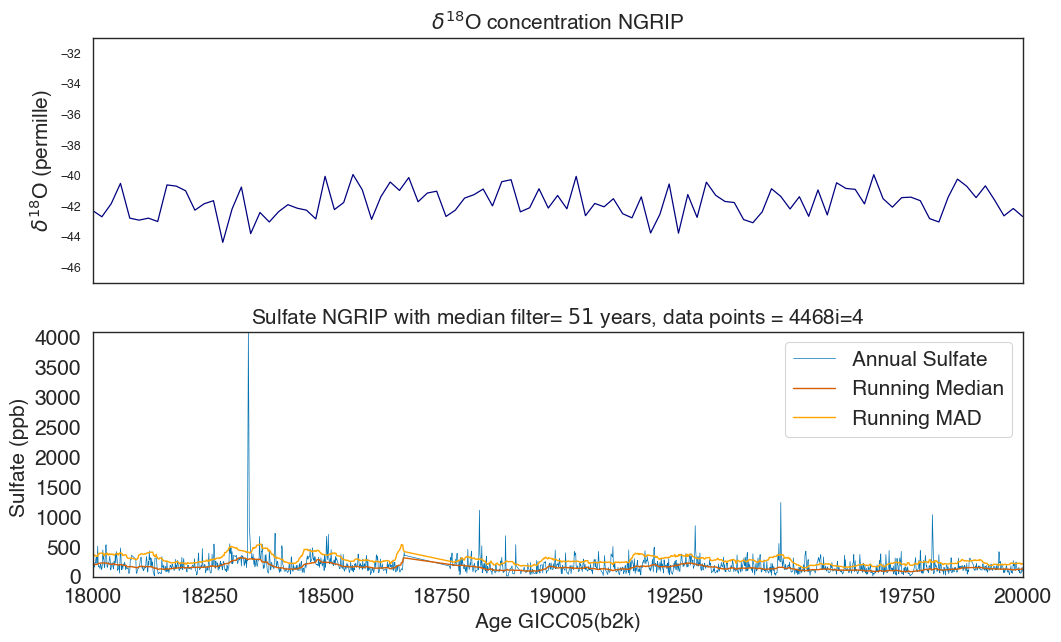

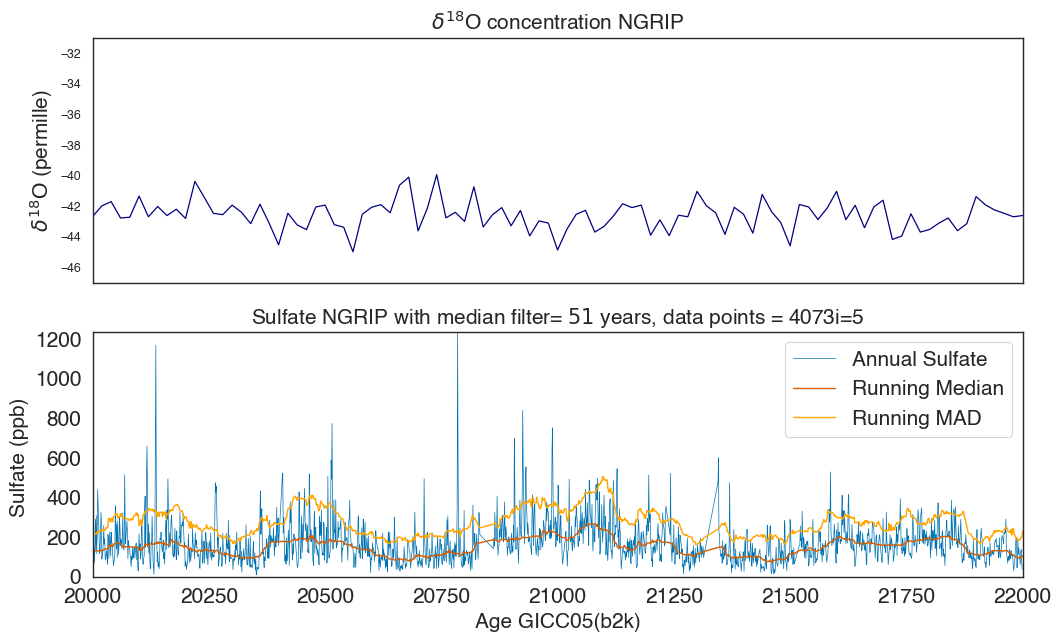

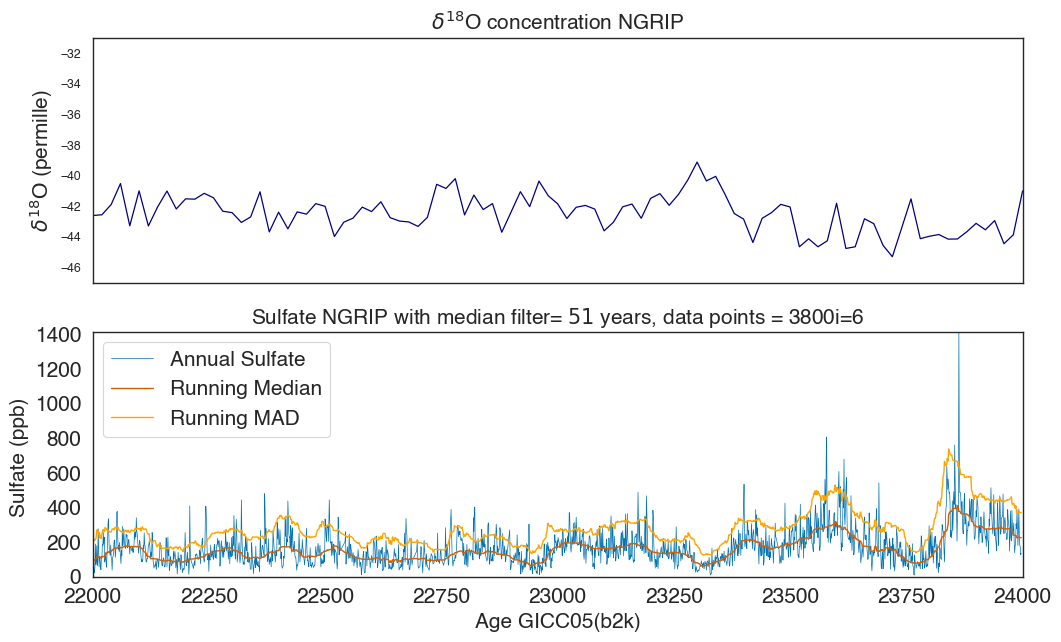

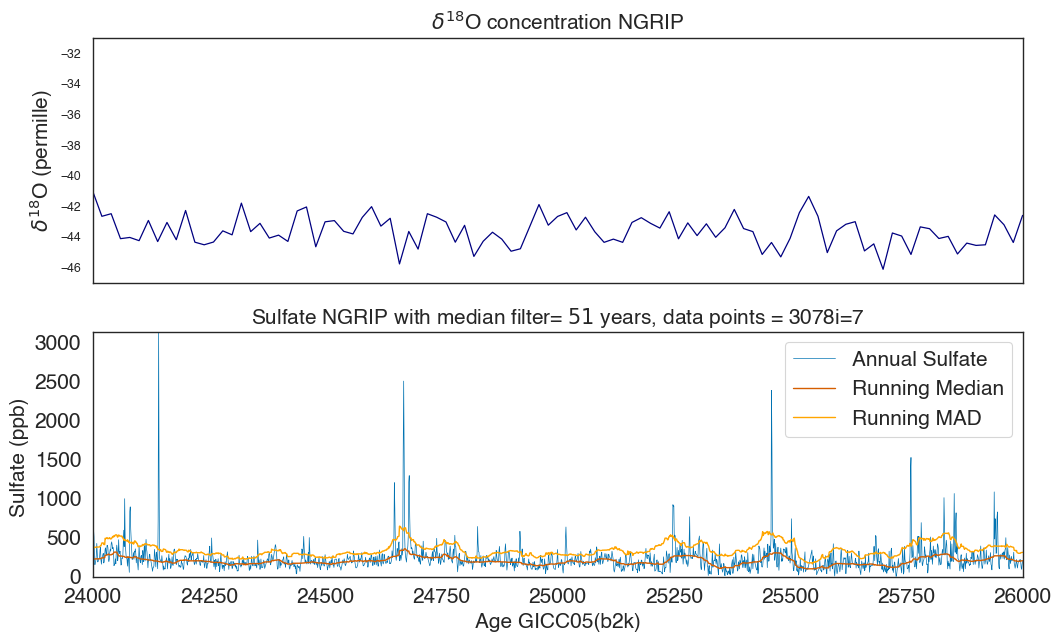

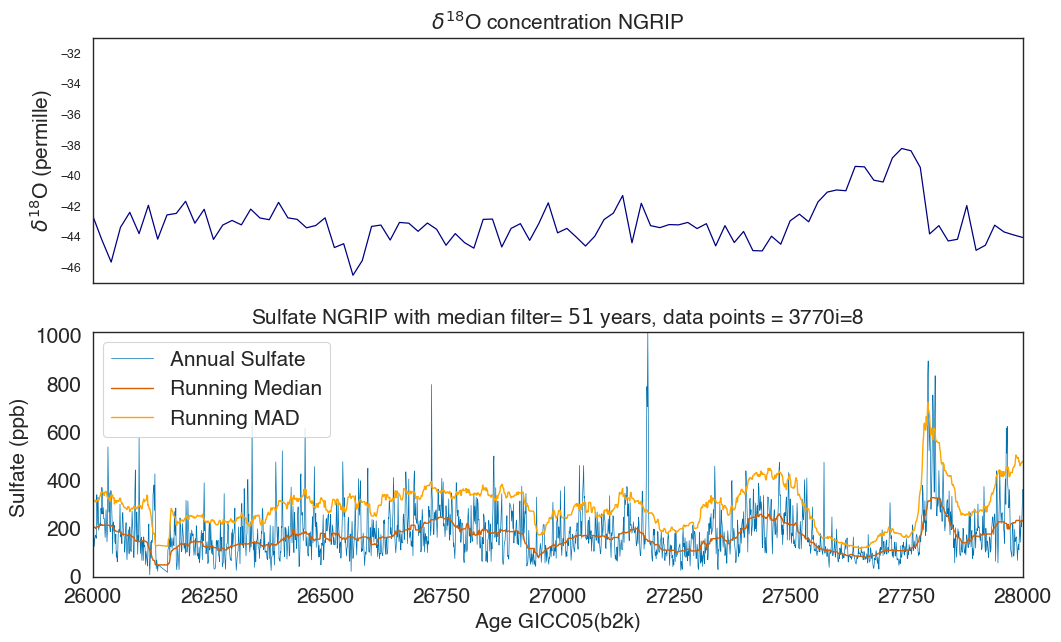

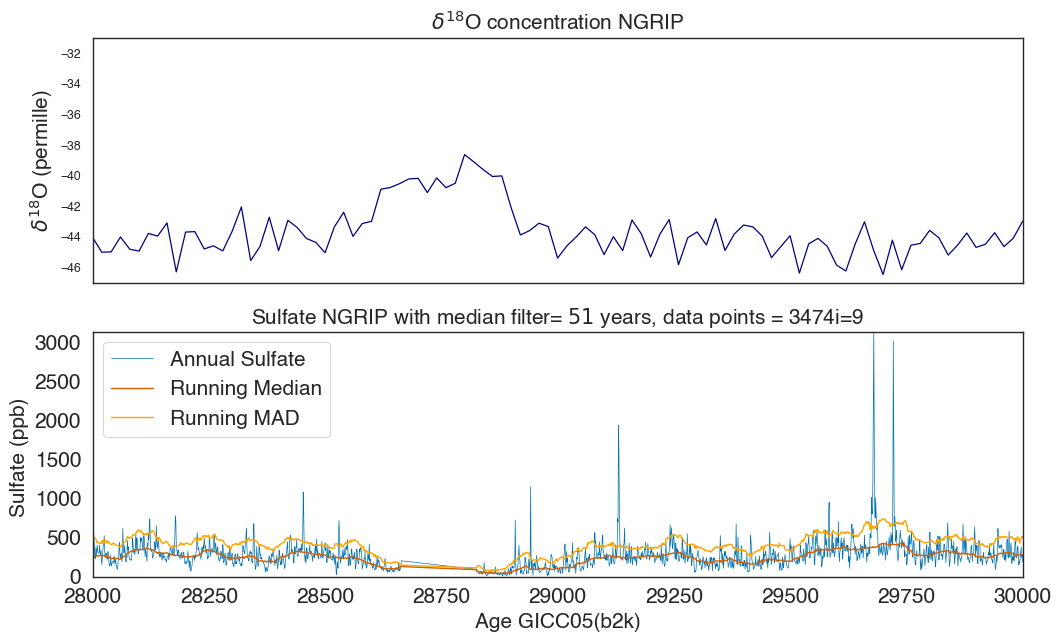

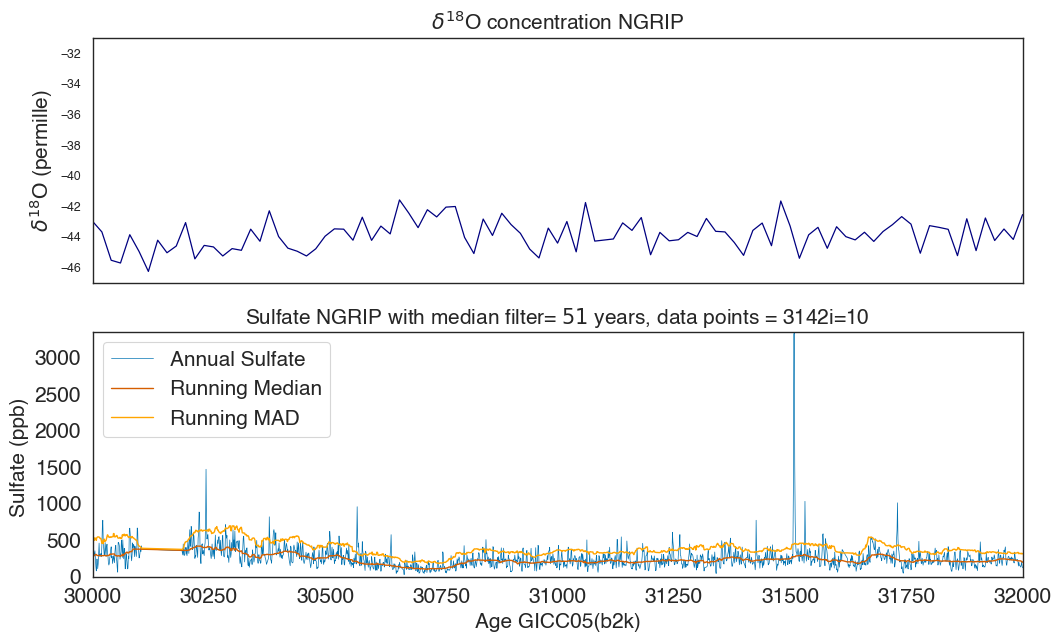

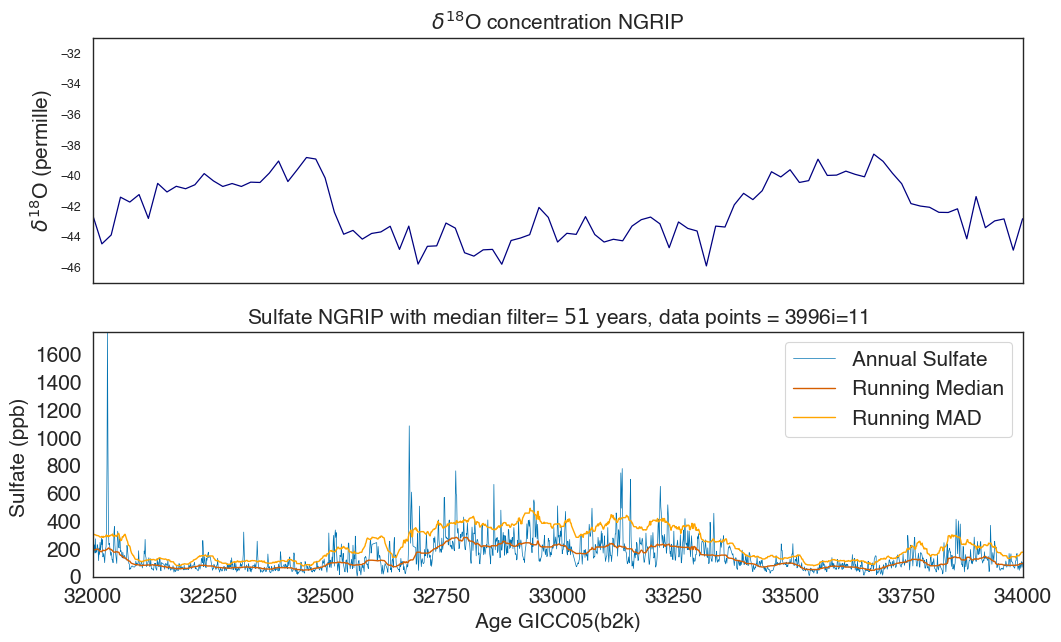

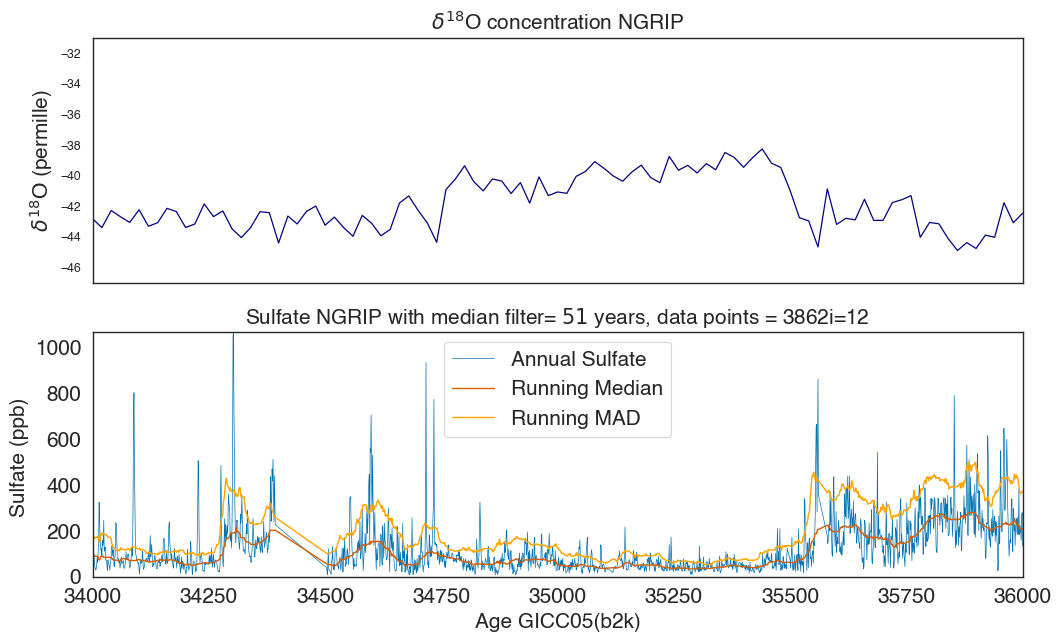

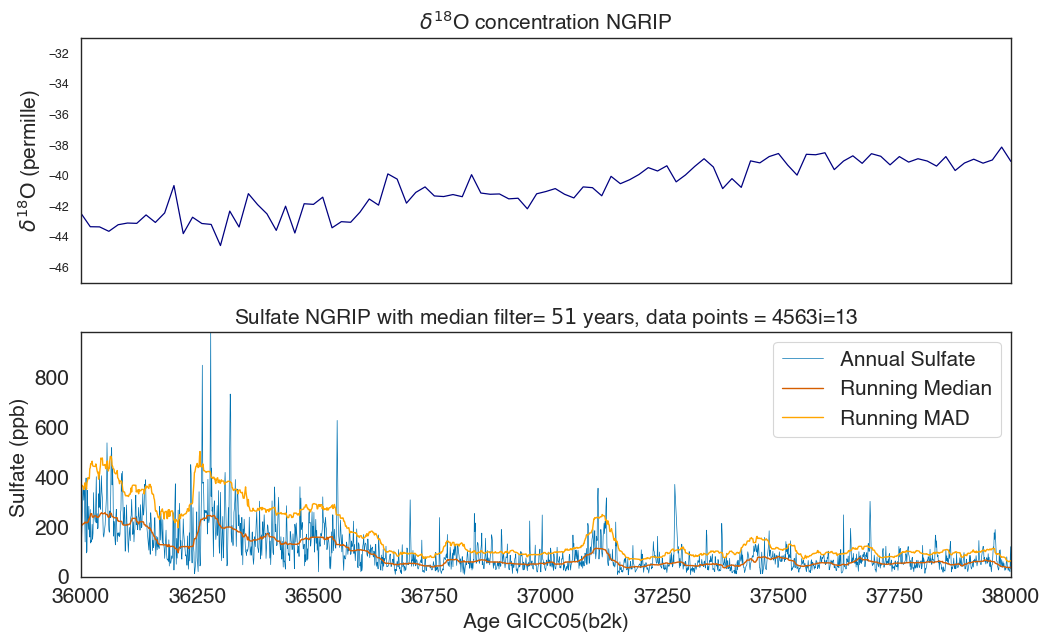

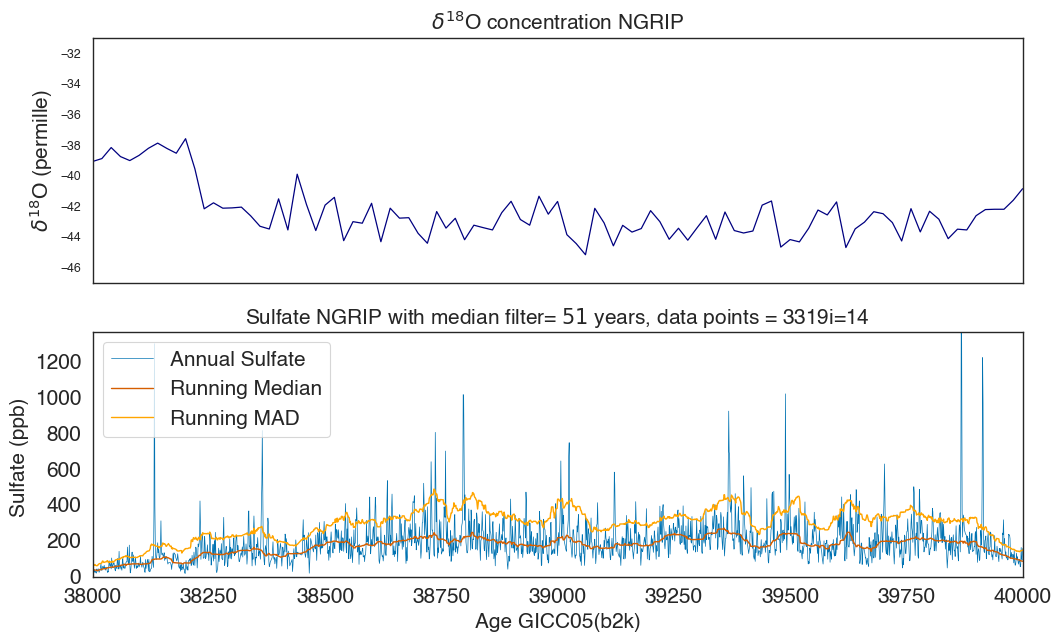

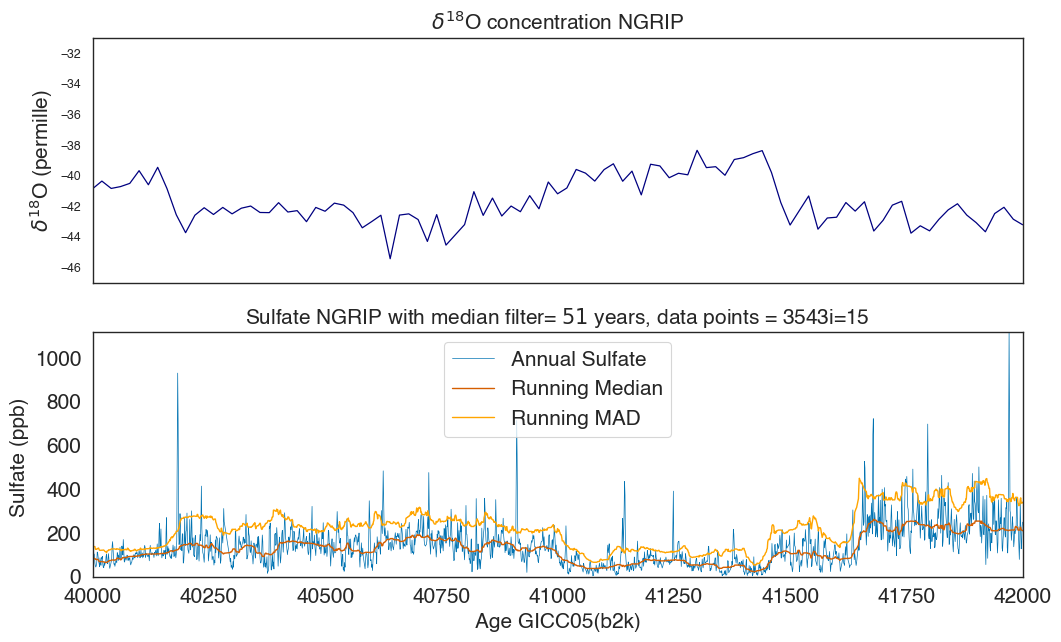

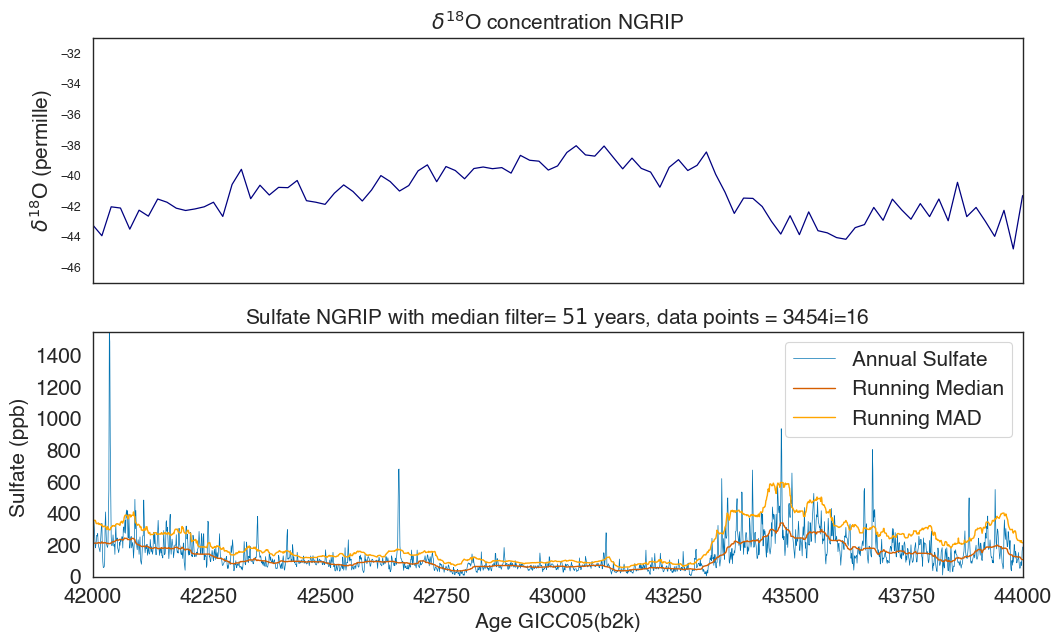

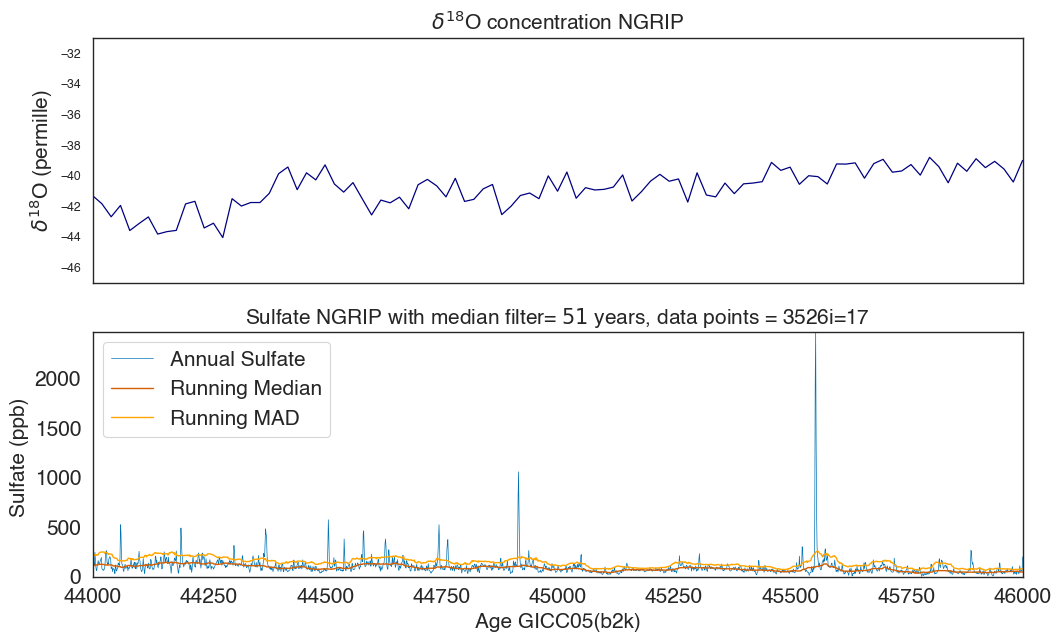

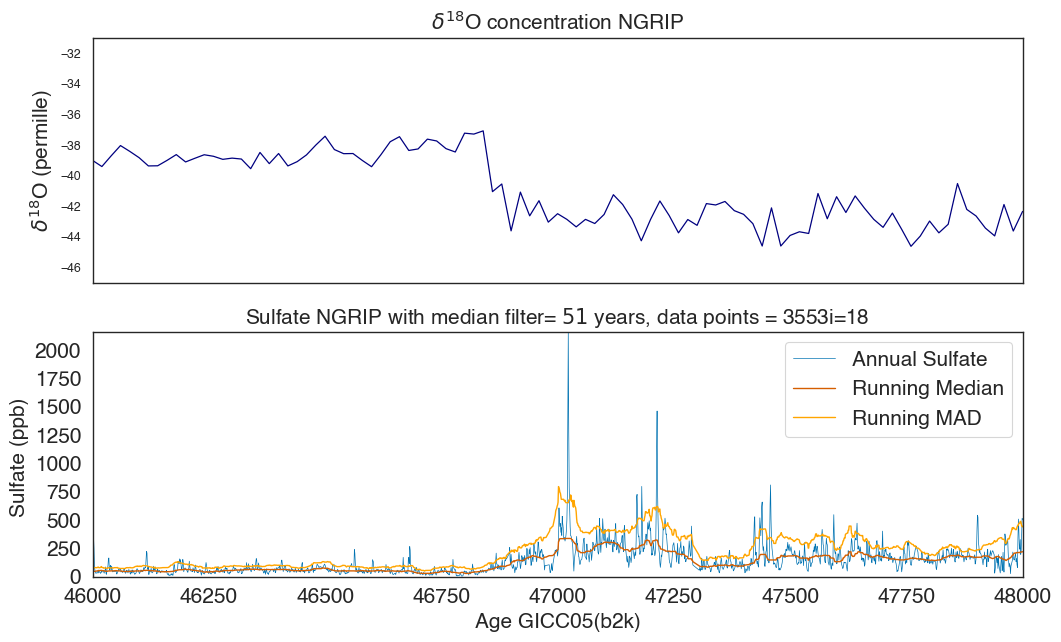

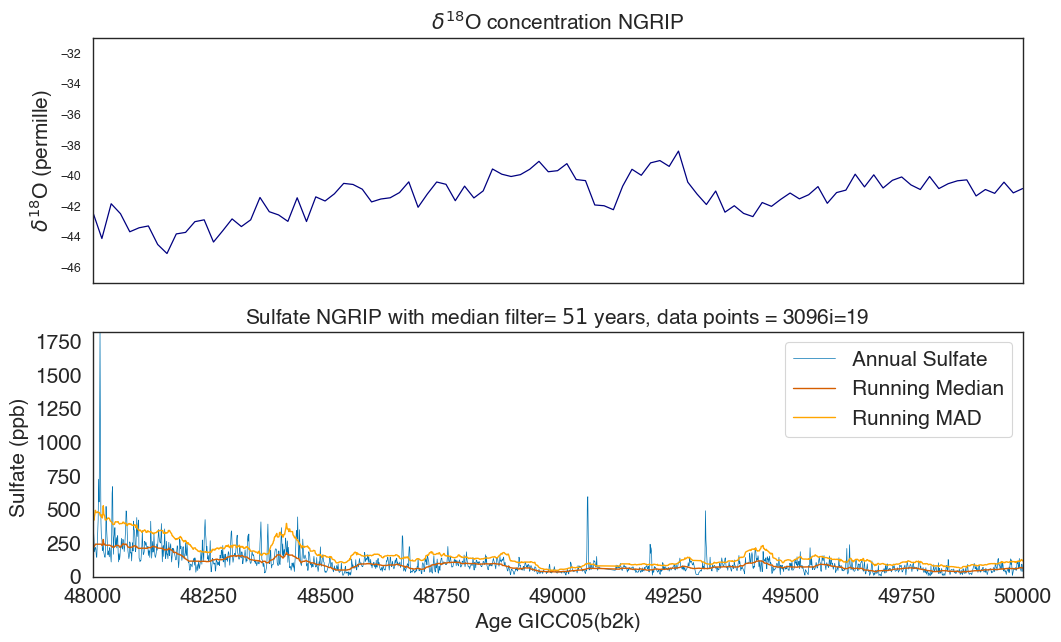

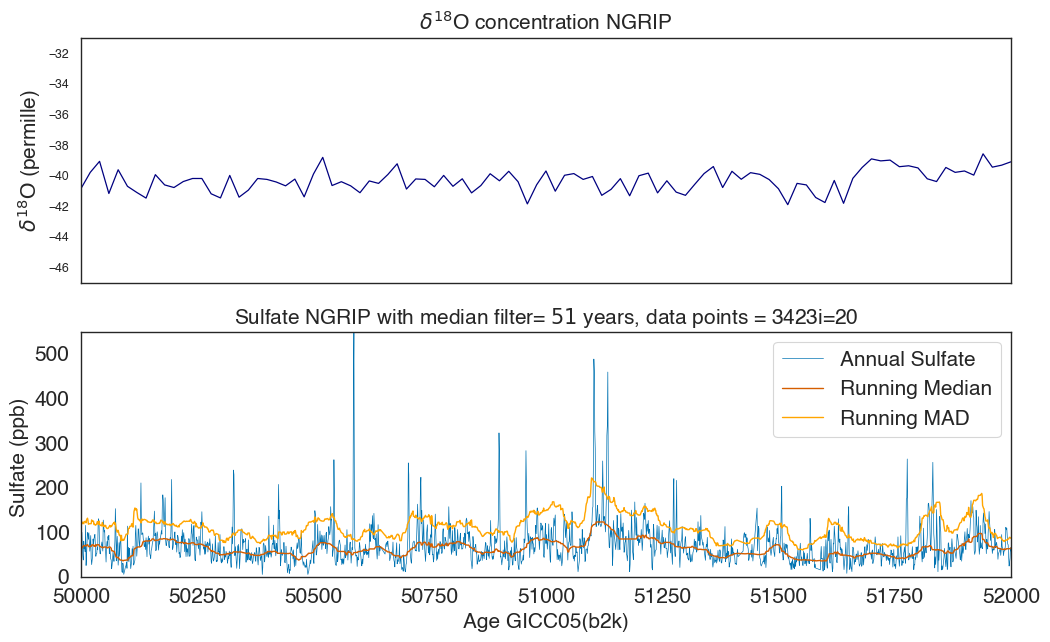

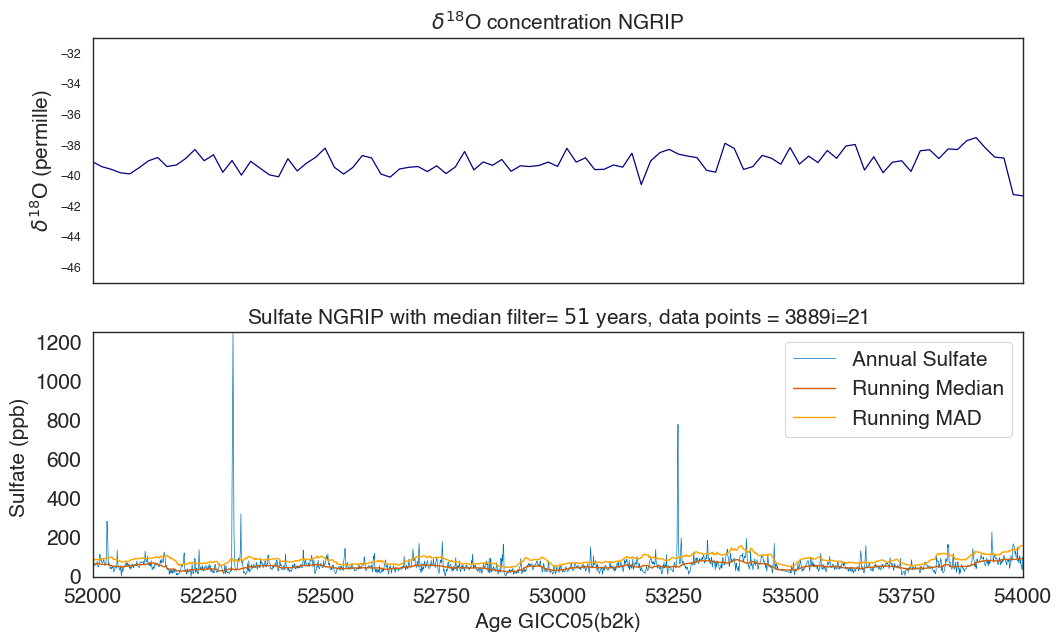

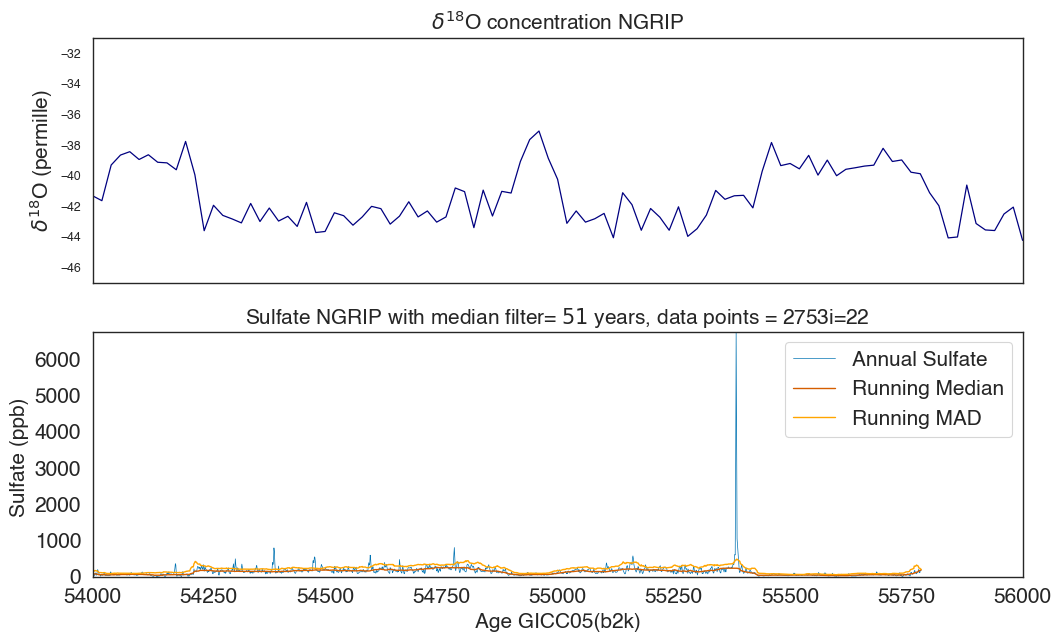

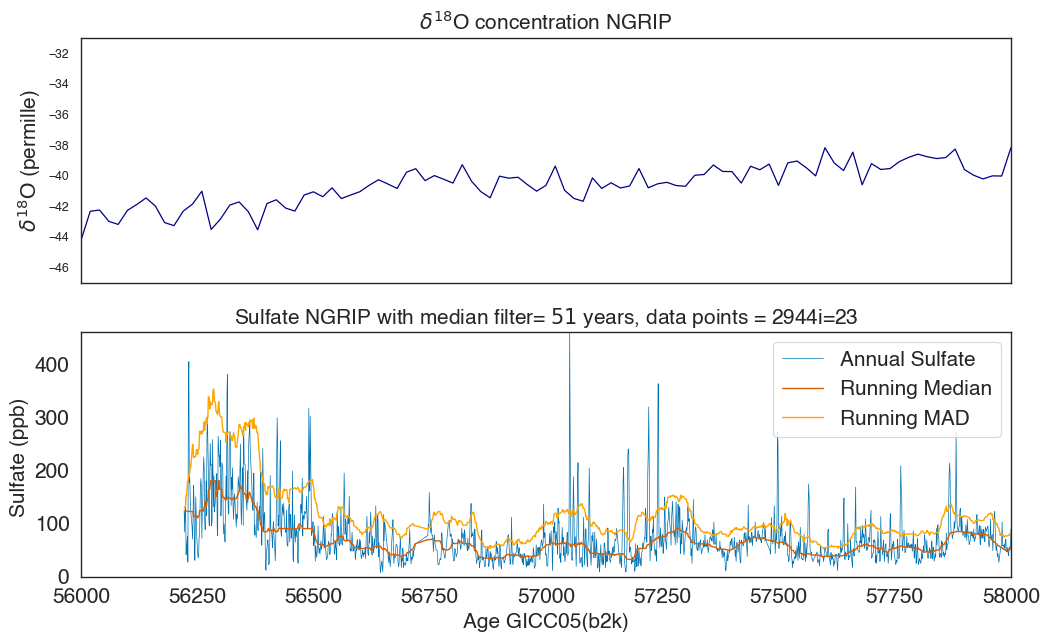

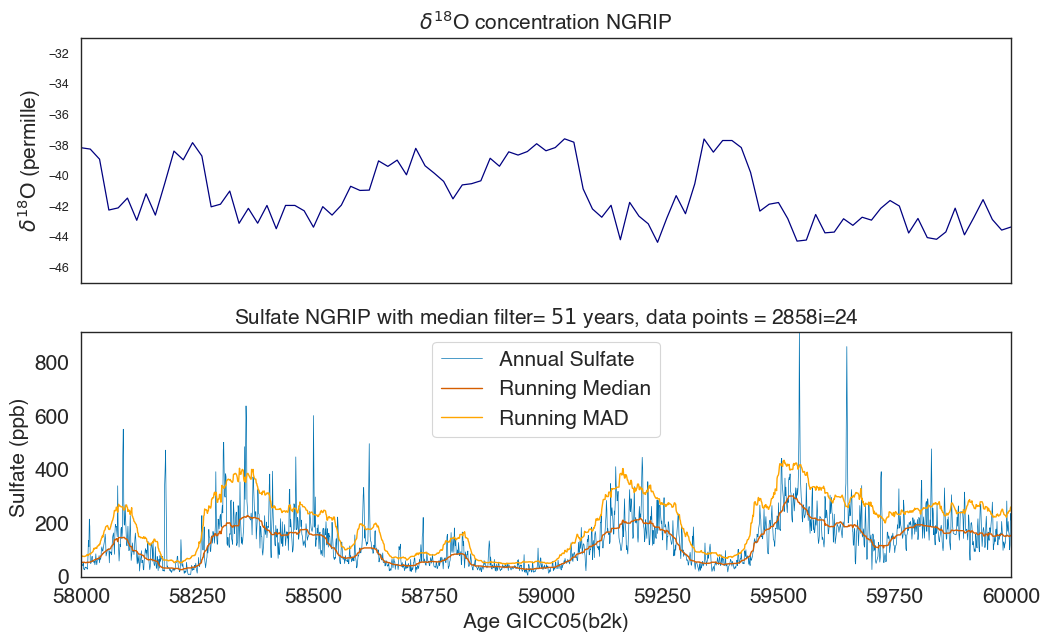

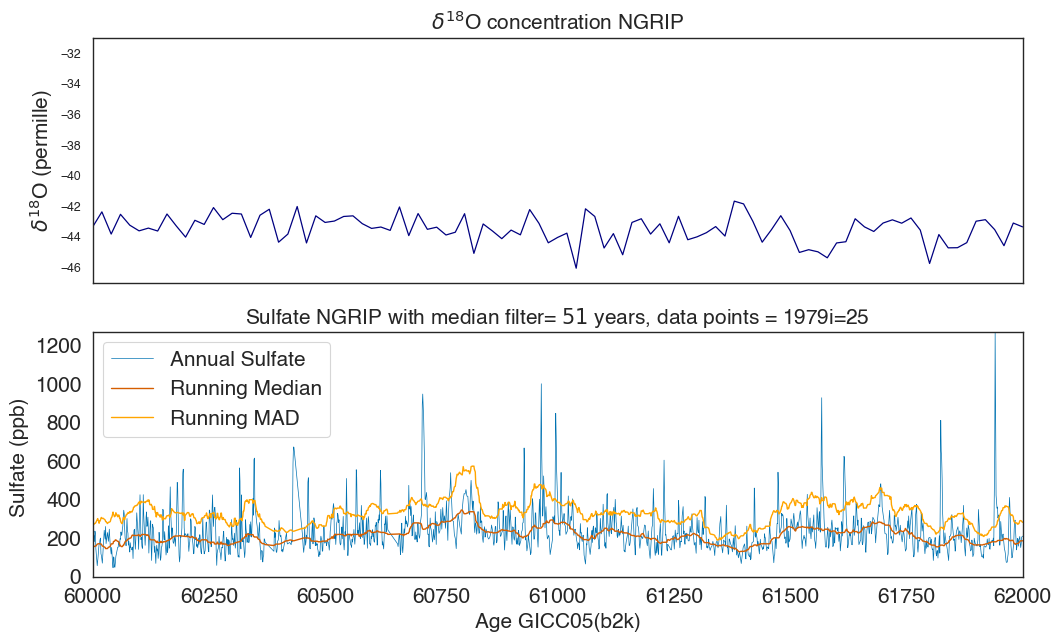

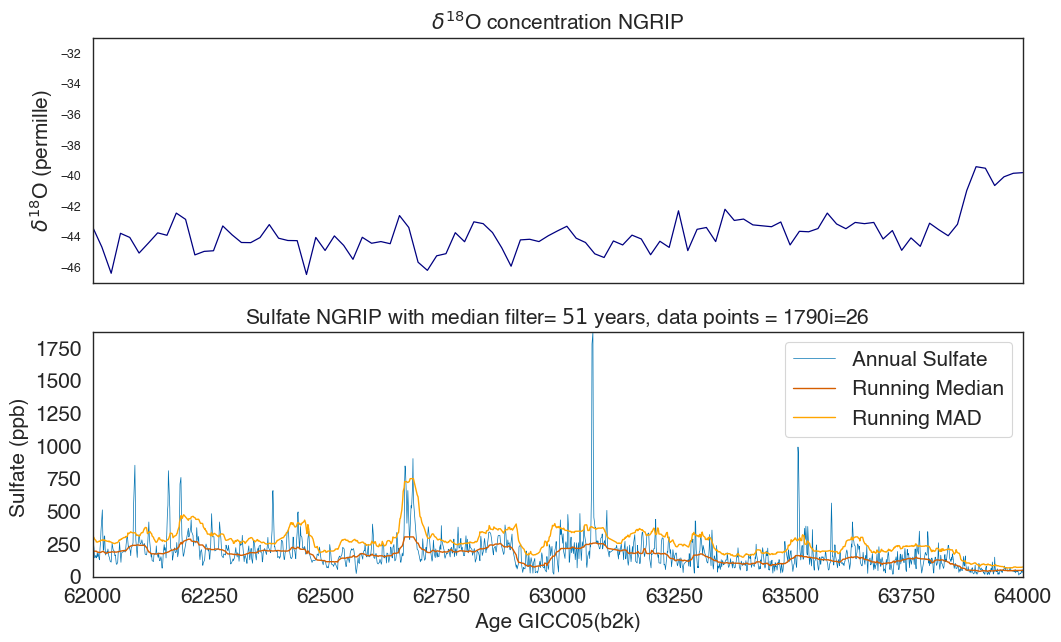

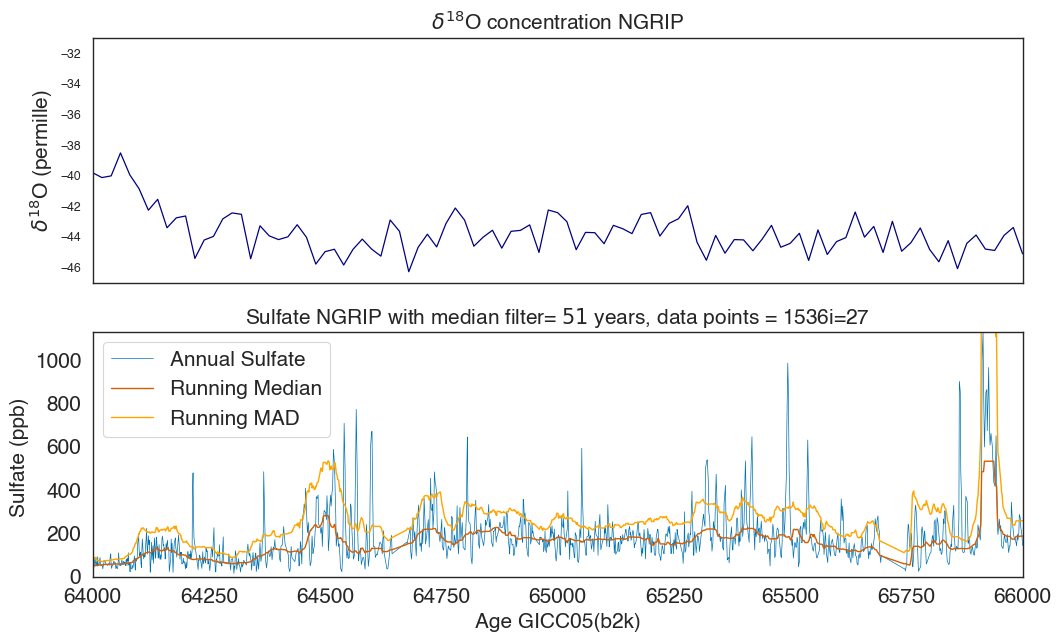

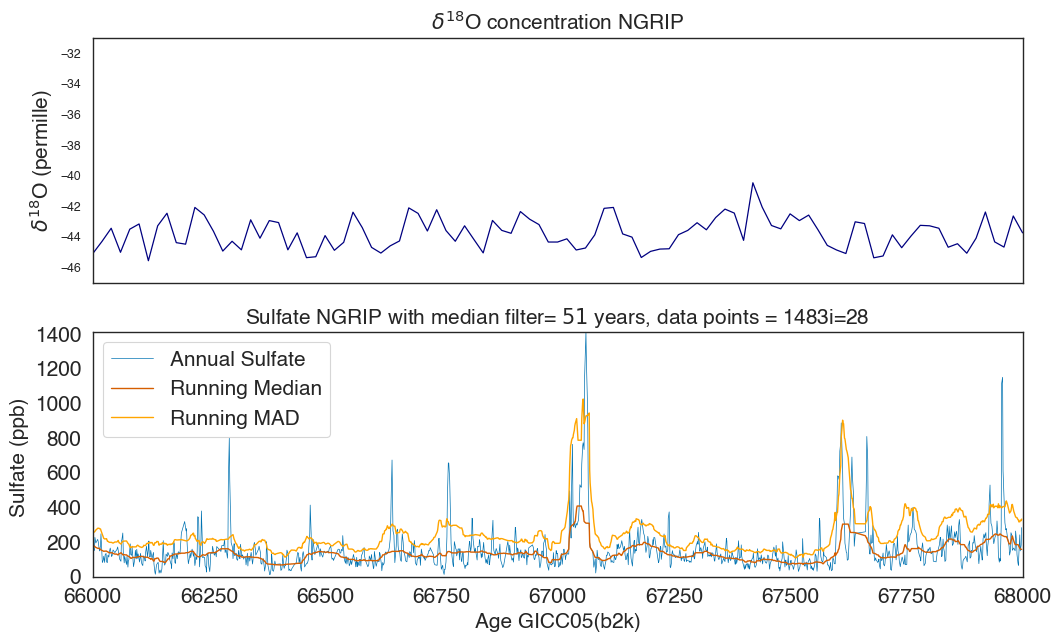

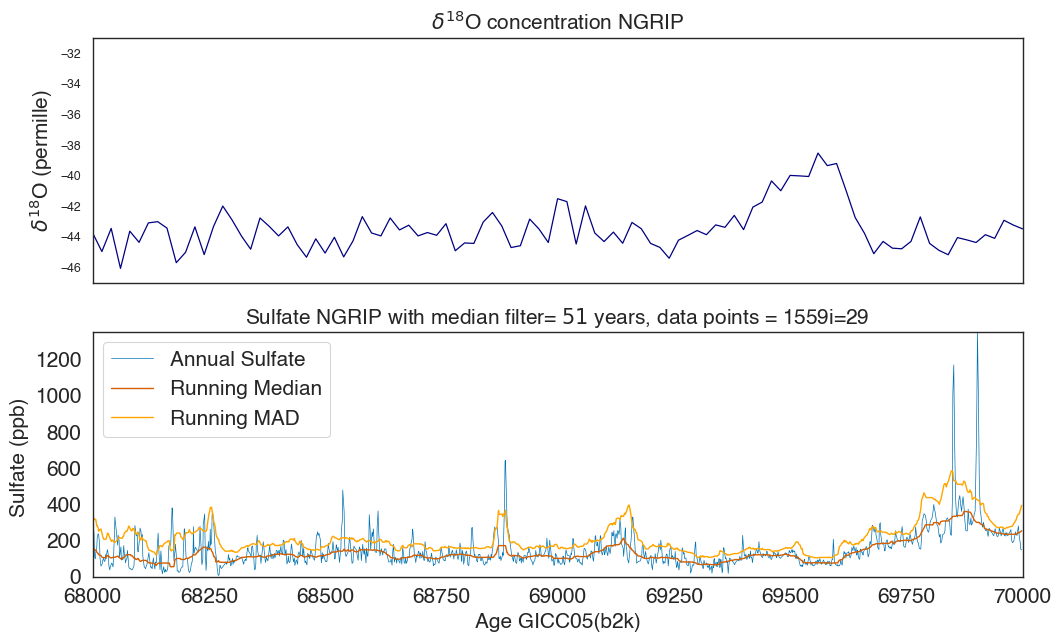

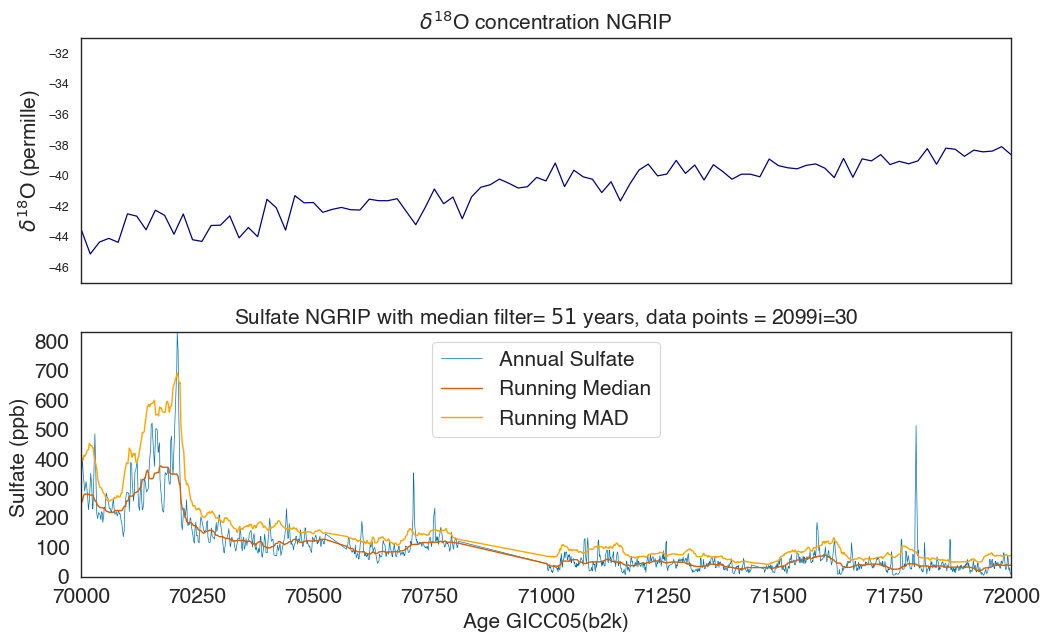

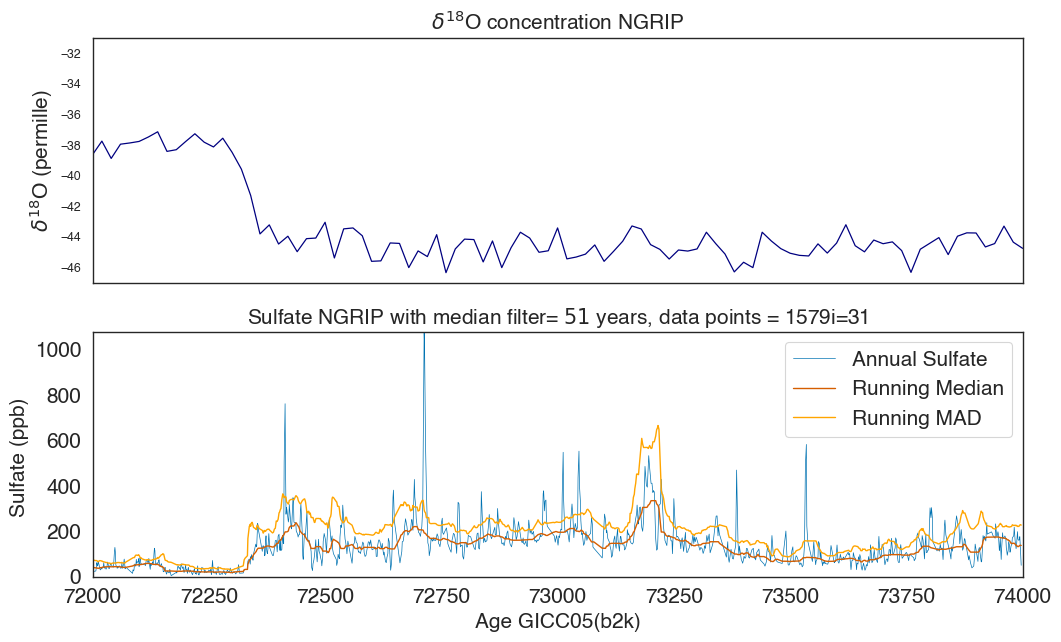

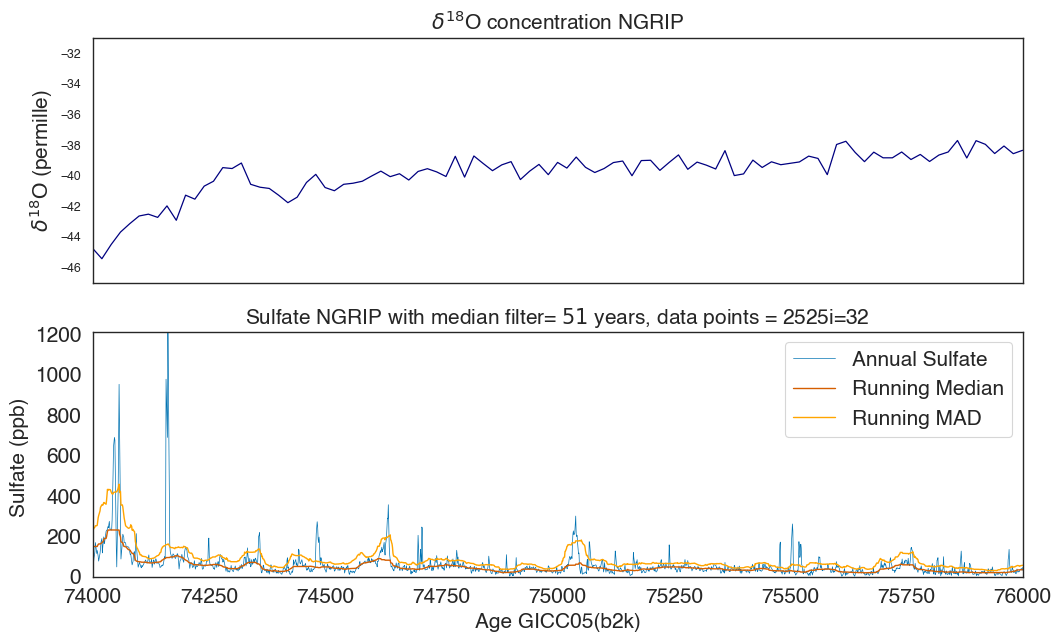

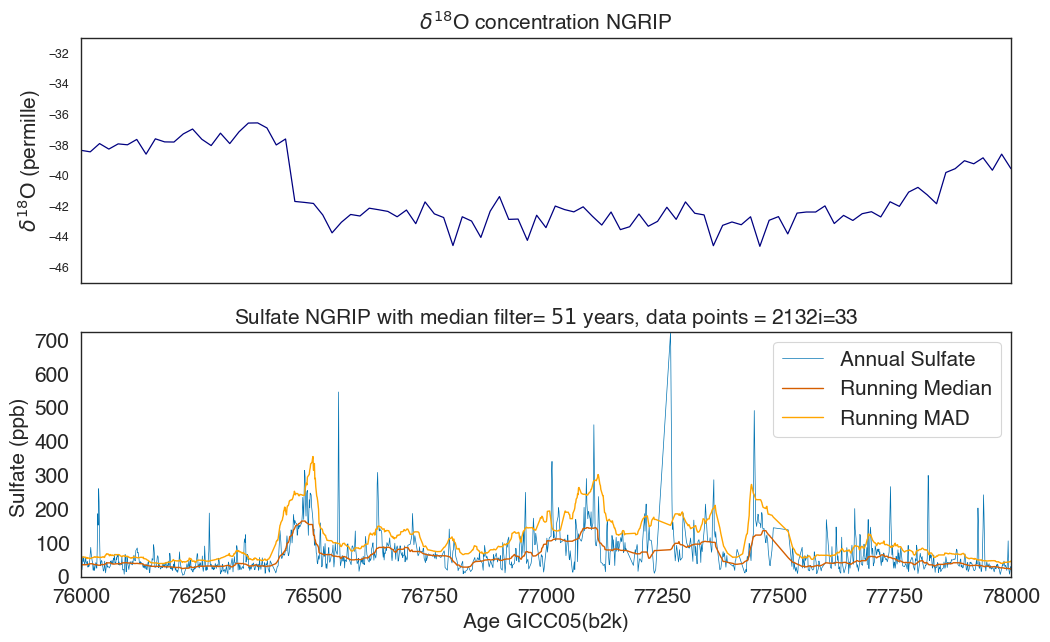

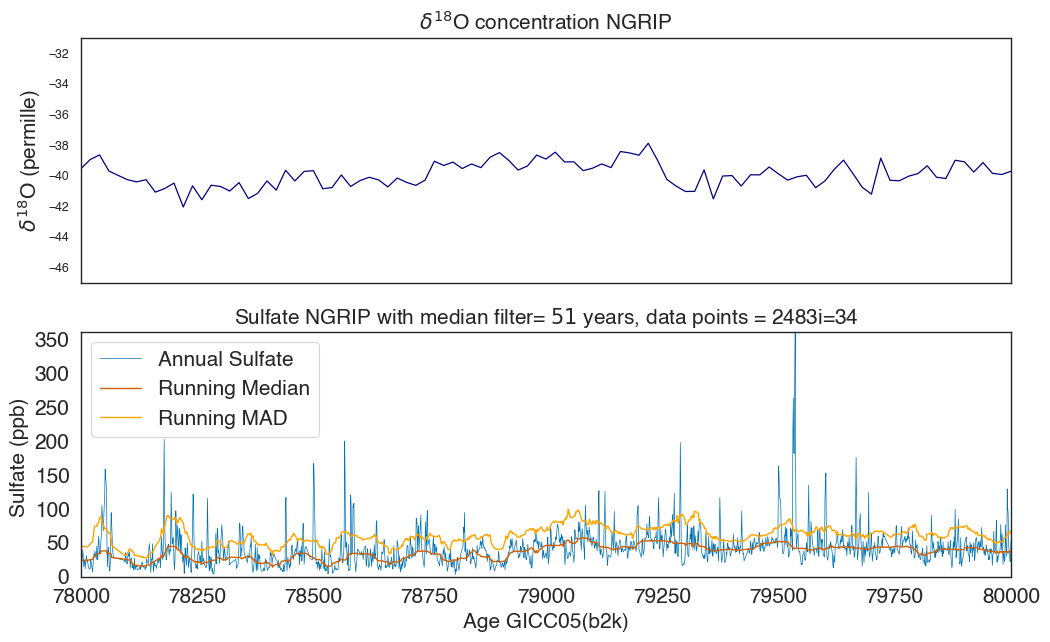

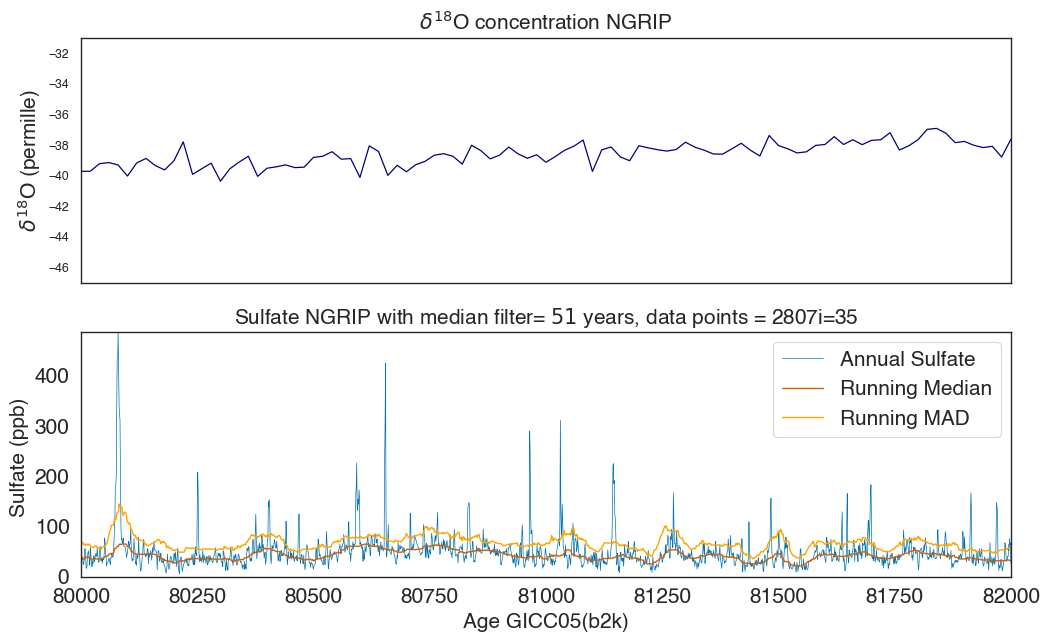

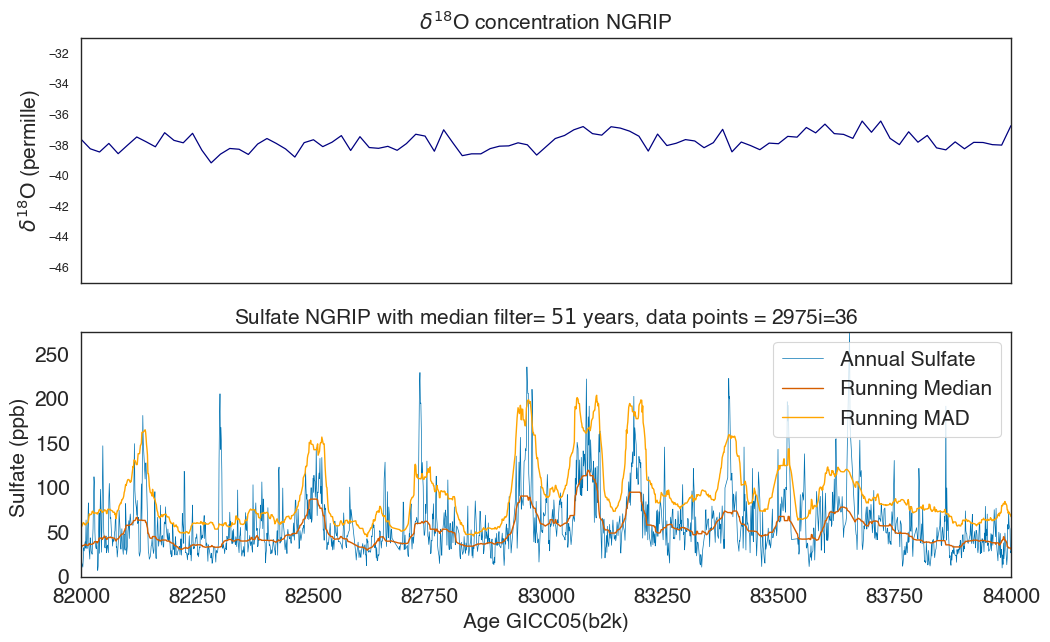

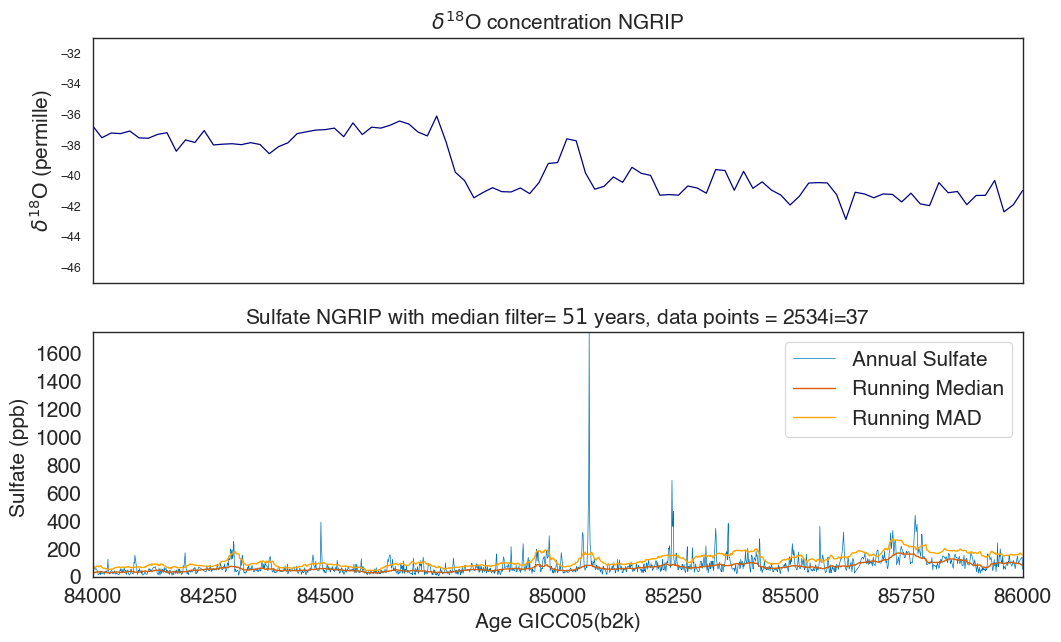

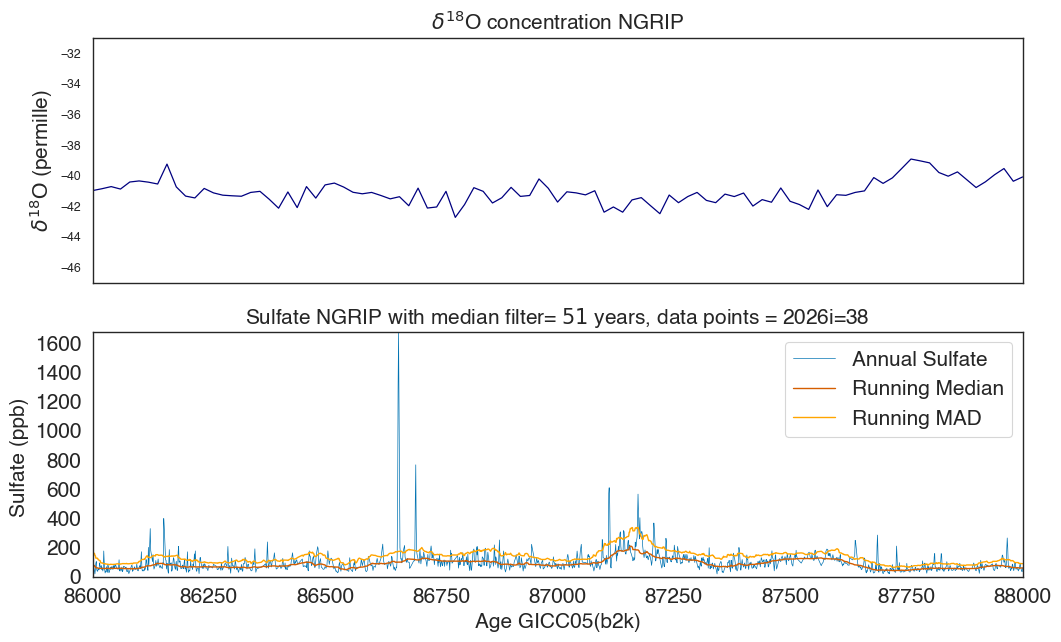

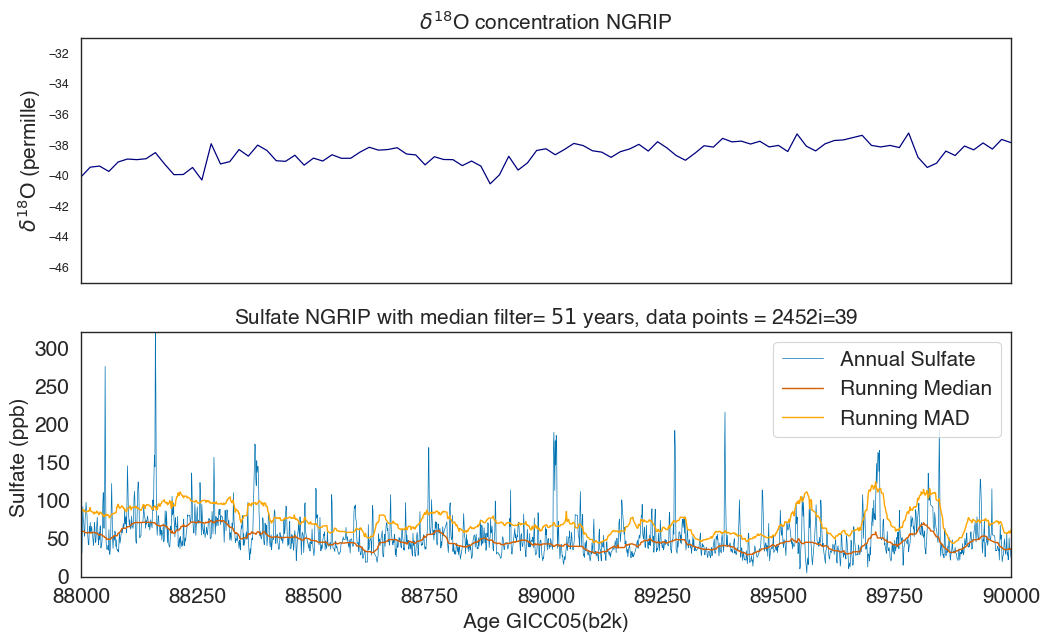

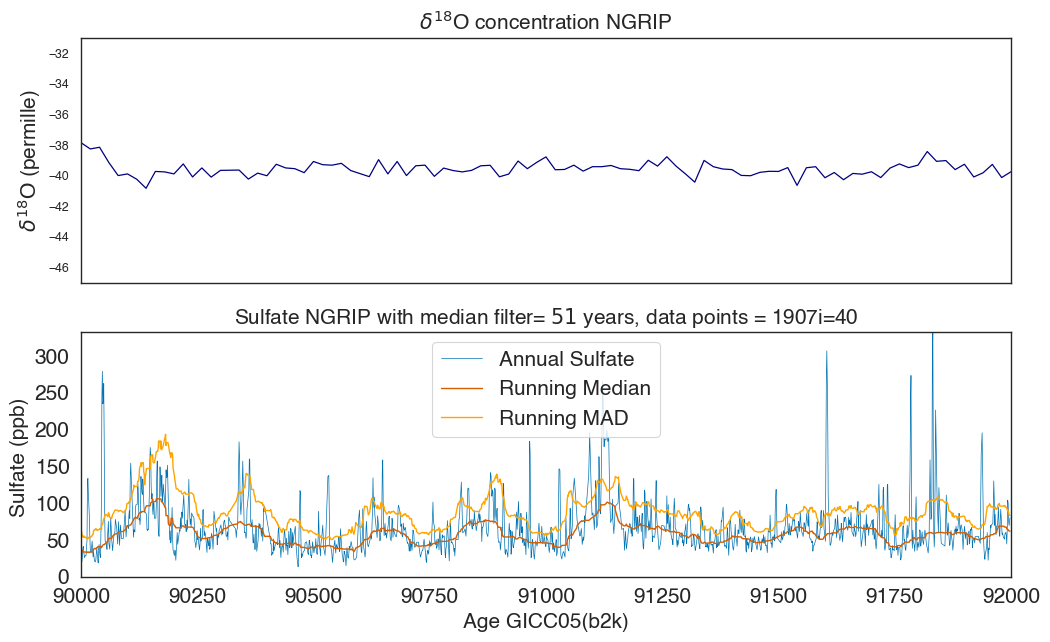

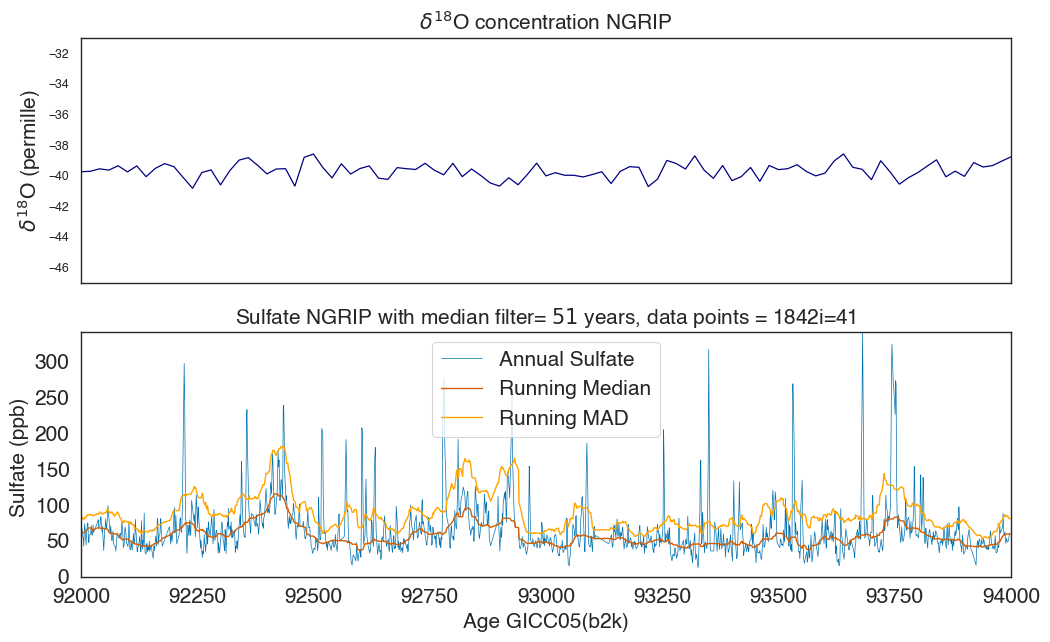

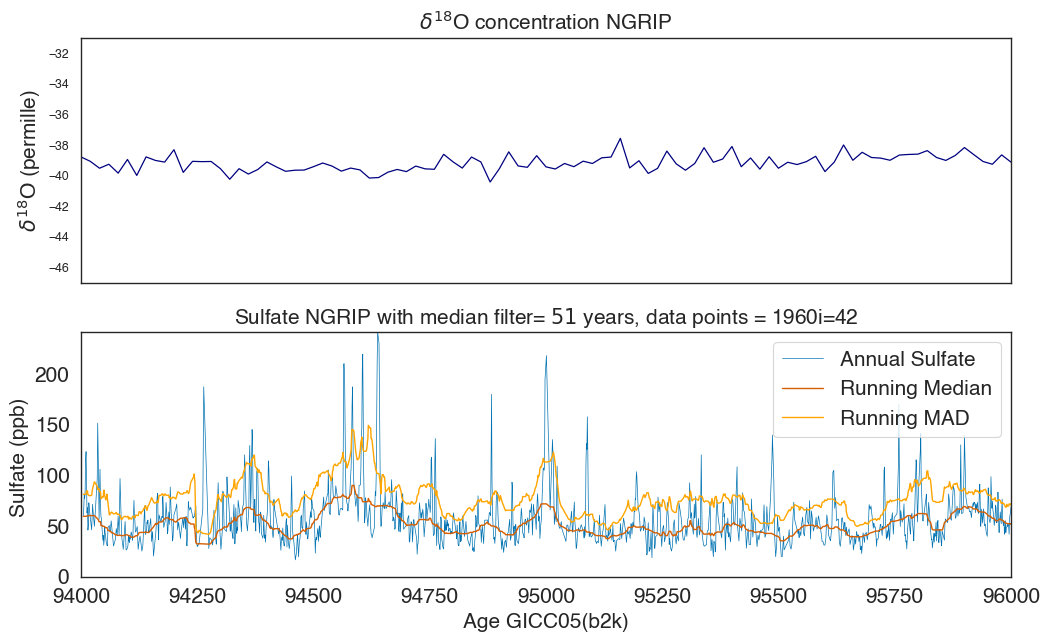

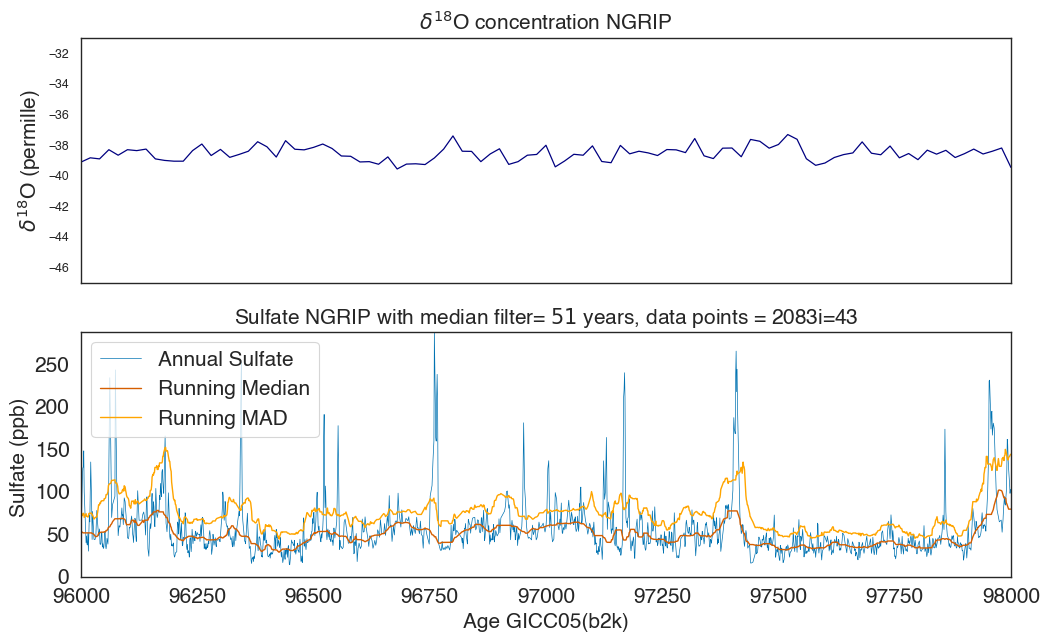

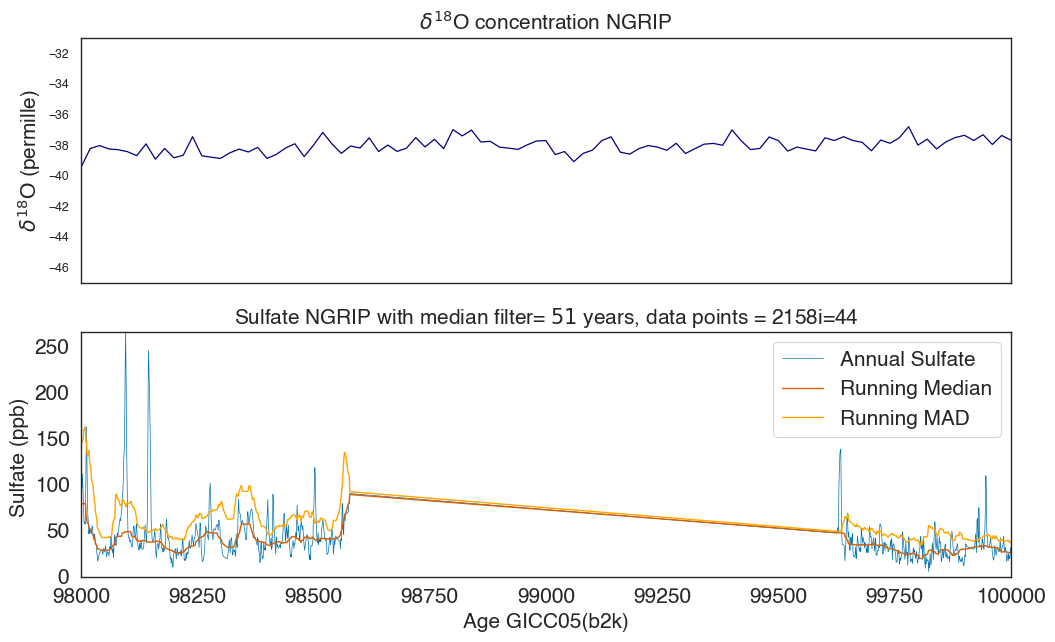

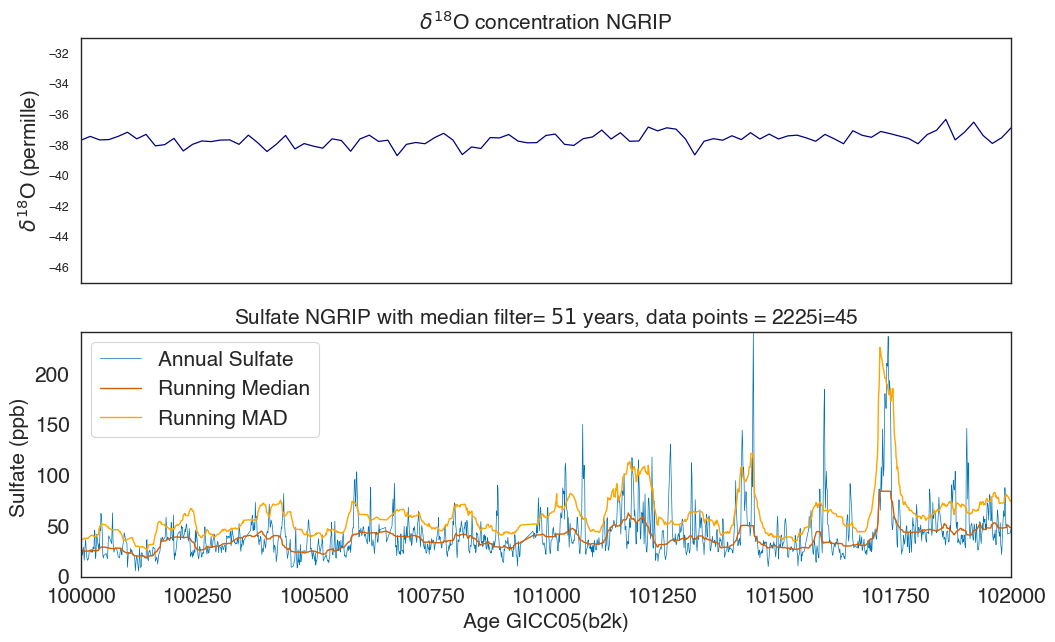

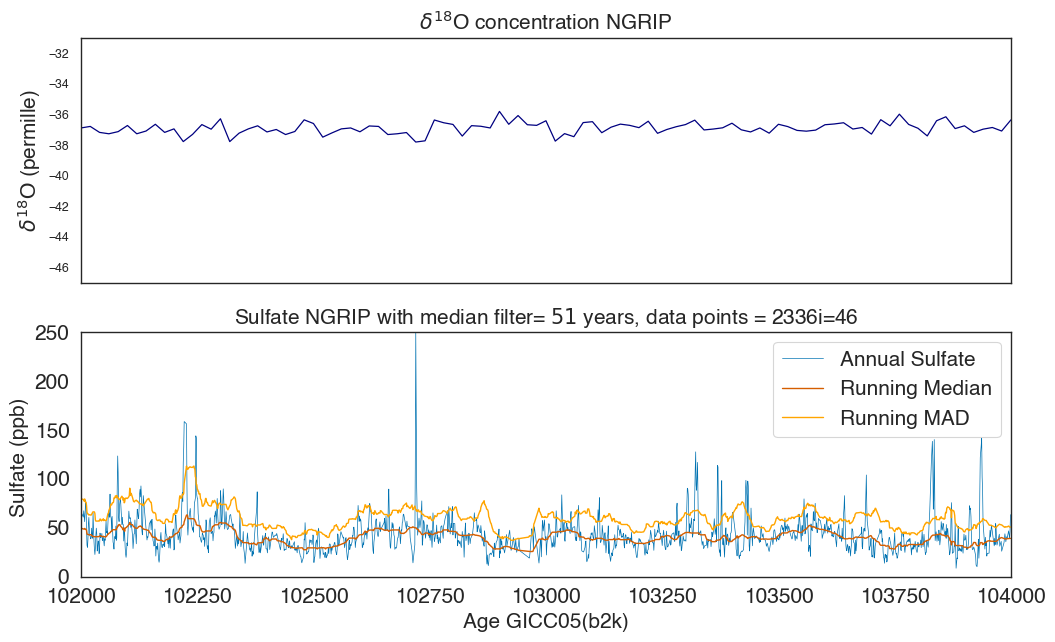

In [22]:
data_points = [] #empty array to count data points 
age_bp = np.interp(depth_bp_NGRIP, NGRIP_depth_annual, NGRIP_annual)

%matplotlib inline

for i in range(len(NGRIP_age_list)-3): 
    
    ### idx for what interval to plot, s = short ###
    idx = np.where((NGRIP_annual >= NGRIP_age_list[i]) & (NGRIP_annual <= NGRIP_age_list[i+1]))
    NGRIP_annual_s = NGRIP_annual[idx] #short array to be plotted 
    NGRIP_annual_sulfate_s = NGRIP_sulfate_annual[idx] #short array to be plotted
    
    ## bp depths within interval ##
    age_bps = age_bp[np.where( (age_bp < NGRIP_annual_s[-1]) & (age_bp > NGRIP_annual_s[0]))]
    age_lost = age_lost_NGRIP[np.where( (age_lost_NGRIP < NGRIP_annual_s[-1]) & (age_lost_NGRIP > NGRIP_annual_s[0]))]
    depth_lost = depths_lost_NGRIP[np.where( (age_lost_NGRIP < NGRIP_annual_s[-1]) & (age_lost_NGRIP > NGRIP_annual_s[0]))]
    depth_bps = depth_bp_NGRIP[np.where( (age_bp < NGRIP_annual_s[-1]) & (age_bp > NGRIP_annual_s[0]))]
    
    ### idx to count the number of data points in each 2k interval ###
    idx_all = np.where((NGRIP_age >= NGRIP_age_list[i]) & (NGRIP_age <= NGRIP_age_list[i+1]))
    NGRIP_sulfate_count = len(NGRIP_sulfate[idx_all])
    data_points.append(NGRIP_sulfate_count)
    
    ### idx to find the d18O data points in each 2k interval ###
    idx_dO18 = np.where((NGRIP_dO18_age >= NGRIP_age_list[i]) & (NGRIP_dO18_age <= NGRIP_age_list[i+1]))
    
    ### Subplots of the 2k intervals ###
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,  figsize=(12, 7))
    colors = ['k','m','g','k','m','g','k','m','g','k','m','g']
    
    # d18O plot #
    ax1.set_title('$\delta^{18}$O concentration NGRIP', fontsize=15)
    ax1.plot(NGRIP_dO18_age[idx_dO18], NGRIP_dO18[idx_dO18], color='navy', linewidth=.9)
    ax1.set_ylabel('$\delta^{18}$O (permille)', fontsize=15)
    ax1.set_ylim(-47,-31)
    
    # sulfate plot #
    ax2.set_title('Sulfate NGRIP with median filter= $'+str(NGRIP_filt)+'$ years, data points = ' + str(NGRIP_sulfate_count) + 'i=' + str(i), fontsize=15)
    ax2.plot(NGRIP_annual_s[np.isfinite(NGRIP_annual_sulfate_s)], NGRIP_annual_sulfate_s[np.isfinite(NGRIP_annual_sulfate_s)], linewidth=.5, label = 'Annual Sulfate', color='b')
    ax2.plot(NGRIP_annual_s[np.isfinite(NGRIP_annual_sulfate_s)], NGRIP_RRM[idx][np.isfinite(NGRIP_annual_sulfate_s)], linewidth = 1, label = 'Running Median', color='r')
    ax2.plot(NGRIP_annual_s[np.isfinite(NGRIP_annual_sulfate_s)], NGRIP_RMAD[idx][np.isfinite(NGRIP_annual_sulfate_s)], linewidth = 1, label = 'Running MAD', color = 'orange')
    #ax1.plot(NGRIP_annual_s, NGRIP_RMAD[idx], linewidth=1, label = 'MAD', color='gold')
    if ~np.isnan(NGRIP_annual_sulfate_s).all():
        ax2.set_ylim(0,np.nanmax(NGRIP_annual_sulfate_s))
    ax2.set_xlabel('Age GICC05(b2k)', fontsize=15)
    ax2.set_ylabel('Sulfate (ppb) ', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax2.set_xlim(NGRIP_age_list[i], NGRIP_age_list[i+1])
    for j in range(len(age_lost )):
        ax2.axvline(x=age_lost[j], ymin=0, ymax=1, color  = colors[j], linewidth=1, label = str(depth_lost[j]))
    ax2.legend(fontsize=15, loc='best')
    #plt.savefig('NGRIP_' + str(NGRIP_annual_s[-1])+ '_' + str(NGRIP_annual_s[0]) + '_' + str(NGRIP_filt) + '_RM_d18O.jpg', dpi=1000, bbox_inches='tight')
    plt.show()

### List with the data resolution and filter length for each interval 

In [23]:
NGRIP_filt_list = NGRIP_filt*np.ones(len(NGRIP_age_list))
#print(tabulate({'Data res.': data_points, 'Interval1': NGRIP_age_list[:-1], 'Interval2': NGRIP_age_list[1:], 'Filter': NGRIP_filt_list[:-1]}, headers="keys", tablefmt='fancy_grid'))

### Plot with data resolution vs. median filter 

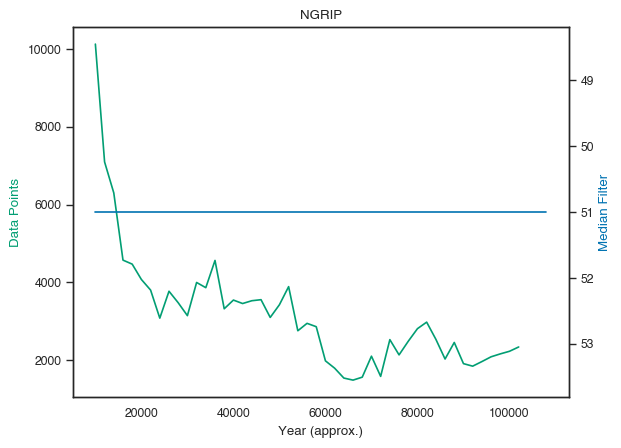

In [24]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(NGRIP_age_list[:-3], data_points, 'g')
ax2.plot(NGRIP_age_list, NGRIP_filt*np.ones(len(NGRIP_age_list)), 'b')

ax1.set_xlabel('Year (approx.)')
ax1.set_ylabel('Data Points', color='g')
ax2.set_ylabel('Median Filter', color='b')
plt.title('NGRIP')
plt.savefig('NGRIP_data_points')
ax2.invert_yaxis()

plt.show()

### Plot with d18O vs. sulfate concentration 

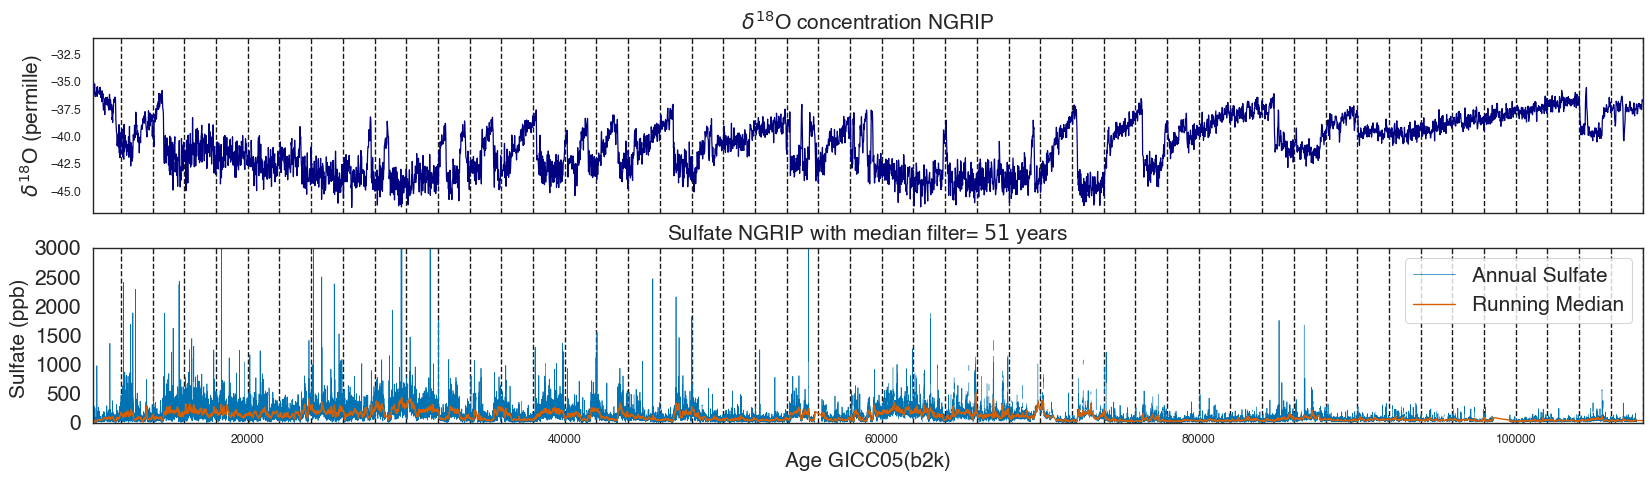

In [25]:
f, (ax1, ax2) = plt.subplots(2, 1,figsize=(20,5), sharex=True)

label_vlines = np.arange(1,len(NGRIP_age_list)+1,1)
NGRIP_age_list_int = [int(x) for x in NGRIP_age_list]

# ax1 #
ax1.vlines(NGRIP_age_list, -47,-31, color='k', linestyle='--', linewidth=1)
ax1.set_title('$\delta^{18}$O concentration NGRIP', fontsize=15)
ax1.plot(NGRIP_dO18_age, NGRIP_dO18, color='navy', linewidth=.9)
ax1.set_ylabel('$\delta^{18}$O (permille)', fontsize=15)
ax1.set_ylim(-47,-31)
ax1.set_xlim(NGRIP_annual[0], NGRIP_annual[-1])

# ax2 #
ax2.vlines(NGRIP_age_list, 0,3000, color='k', linestyle='--', linewidth=1)
ax2.set_title('Sulfate NGRIP with median filter= $'+str(NGRIP_filt)+'$ years', fontsize=15)
ax2.plot(NGRIP_annual, NGRIP_sulfate_annual, linewidth=.5, label = 'Annual Sulfate', color='b')
ax2.plot(NGRIP_annual, NGRIP_RRM, linewidth = 1, label = 'Running Median', color='r')
#ax1.plot(NGRIP_annual_s, NGRIP_MAD[idx], linewidth=1, label = 'MAD', color='gold')
ax2.legend(fontsize=15, loc='best')
ax2.set_ylim(0,3000)
ax2.set_xlabel('Age GICC05(b2k)', fontsize=15)
ax2.set_ylabel('Sulfate (ppb) ', fontsize=15)
#plt.xticks(NGRIP_age_list, NGRIP_age_list_int, fontsize=10,rotation=90)
plt.yticks(fontsize=15)
plt.xlabel('Age GICC05(b2k)', fontsize=15)
#ax2.set_xlim(NGRIP_age_list[i], NGRIP_age_list[i+1])
#plt.savefig('NGRIP_' + str(NGRIP_filt) + '_RM_d18O_intevals.jpg', dpi=1000, bbox_inches='tight')
plt.show()

### Finding the sulfate deposition in the ice core 

In [26]:
### Empty arrays ###
sulfate = []
y = []
sulfate_dep = []
year=[]

NGRIP_sulfate_annual = interp(NGRIP_sulfate_annual)
NGRIP_RRM = interp(NGRIP_RRM)

### Loop to find the sulfate deposition including thinning ###
for i in range(len(NGRIP_annual)):
    if NGRIP_sulfate_annual[i] > NGRIP_RMAD[i]:
        sulfate.append(  (  (NGRIP_sulfate_annual[i] - NGRIP_RRM[i]) * NGRIP_annual_thickness[i] / NGRIP_annual_thinning[i] ) * 0.917 )
        y.append(NGRIP_annual[i])
    else:
        if len(sulfate) != 0: 
            sulfate_dep.append(np.sum(sulfate))
            year.append(y[0])
            
            sulfate = []
            y = []
            
        else:
            continue


In [27]:
'''sulfate = []
y = []
sulfate_dep = []
year=[]

%store -r JL_NGRIP_age_start
%store -r JL_NGRIP_age_middle
%store -r JL_NGRIP_age_end
%store -r JL_NGRIP_s

NGRIP_RRM = np.array(NGRIP_RRM)

#for j in range(len(NGRIP_age)):
for i in range(len(JL_NGRIP_s)):
    if JL_NGRIP_age_start[i] == np.nan:
        continue
    else:
        idx = np.where((NGRIP_annual >=JL_NGRIP_age_start[i] -0.1) & (NGRIP_annual <=JL_NGRIP_age_end[i]+0.1))
        if len(idx[0]) == 0:
            continue
        else:
            s =   ( ( (NGRIP_sulfate_annual[idx[0]] - NGRIP_RRM[idx[0]]) * NGRIP_annual_thickness[idx[0]] / NGRIP_annual_thinning[idx[0]] ) * 0.917 )
            y = JL_NGRIP_age_start[i]
            sulfate_dep.append(np.nansum(s))
            year.append(y)
        
print(len(JL_NGRIP_s), len(JL_NGRIP_age_start))

JL_NGRIP_s = np.array(JL_NGRIP_s, dtype='float64')
JL_NGRIP_age_start=np.array(JL_NGRIP_age_start, dtype='float64')

JL_NGRIP_s = JL_NGRIP_s[~np.isnan(JL_NGRIP_s)]
JL_NGRIP_age_start = JL_NGRIP_age_start[~np.isnan(JL_NGRIP_age_start)]

print(len(JL_NGRIP_s), len(JL_NGRIP_age_start), len(sulfate_dep))

corr = pearsonr(JL_NGRIP_s, sulfate_dep)

header = ('year', 'SO4-2', 'year Jiamei', 'sulfate dep Jiamei')

table = zip(year, sulfate_dep, JL_NGRIP_age_start, JL_NGRIP_s)

print(tabulate(table, headers=header, floatfmt=".4f")) '''

'sulfate = []\ny = []\nsulfate_dep = []\nyear=[]\n\n%store -r JL_NGRIP_age_start\n%store -r JL_NGRIP_age_middle\n%store -r JL_NGRIP_age_end\n%store -r JL_NGRIP_s\n\nNGRIP_RRM = np.array(NGRIP_RRM)\n\n#for j in range(len(NGRIP_age)):\nfor i in range(len(JL_NGRIP_s)):\n    if JL_NGRIP_age_start[i] == np.nan:\n        continue\n    else:\n        idx = np.where((NGRIP_annual >=JL_NGRIP_age_start[i] -0.1) & (NGRIP_annual <=JL_NGRIP_age_end[i]+0.1))\n        if len(idx[0]) == 0:\n            continue\n        else:\n            s =   ( ( (NGRIP_sulfate_annual[idx[0]] - NGRIP_RRM[idx[0]]) * NGRIP_annual_thickness[idx[0]] / NGRIP_annual_thinning[idx[0]] ) * 0.917 )\n            y = JL_NGRIP_age_start[i]\n            sulfate_dep.append(np.nansum(s))\n            year.append(y)\n        \nprint(len(JL_NGRIP_s), len(JL_NGRIP_age_start))\n\nJL_NGRIP_s = np.array(JL_NGRIP_s, dtype=\'float64\')\nJL_NGRIP_age_start=np.array(JL_NGRIP_age_start, dtype=\'float64\')\n\nJL_NGRIP_s = JL_NGRIP_s[~np.isnan(

### Finding the sulfate peaks that the two results have in common 

In [28]:
### empty arrays ###
y_mydata = []
s_mydata = []
y_lin = []
s_lin = []

### lists to arrays ###
sulfate_dep = np.array(sulfate_dep)
year=np.array(year)

### Detection limit sulfate depostion ###
limit = 0

### Results using the detection limit ###
NGRIP_jiamei_age_s = NGRIP_jiamei_age[NGRIP_jiamei_dep>limit]
NGRIP_jiamei_dep_s = NGRIP_jiamei_dep[NGRIP_jiamei_dep >limit]
year_s = year[sulfate_dep>limit]
sulfate_dep_s = sulfate_dep[sulfate_dep >limit]

### Finding the sulfate deposition the results have in common ###
for i in range(len(year_s)):
    for j in range(len(NGRIP_jiamei_dep_s)):
        if np.abs(NGRIP_jiamei_age_s[j]-year_s[i]) < 1 :
            y_mydata.append(year_s[i])
            s_mydata.append(sulfate_dep_s[i])
            y_lin.append(NGRIP_jiamei_age_s[j])
            s_lin.append(NGRIP_jiamei_dep_s[j])
        else:
            continue

### lists to arrays ###
y_mydata = np.array(y_mydata)
s_mydata = np.array(s_mydata)
y_lin = np.array(y_lin)
s_lin = np.array(s_lin)

### Plot of the sulfate deposition in the whole core (NGRIP)

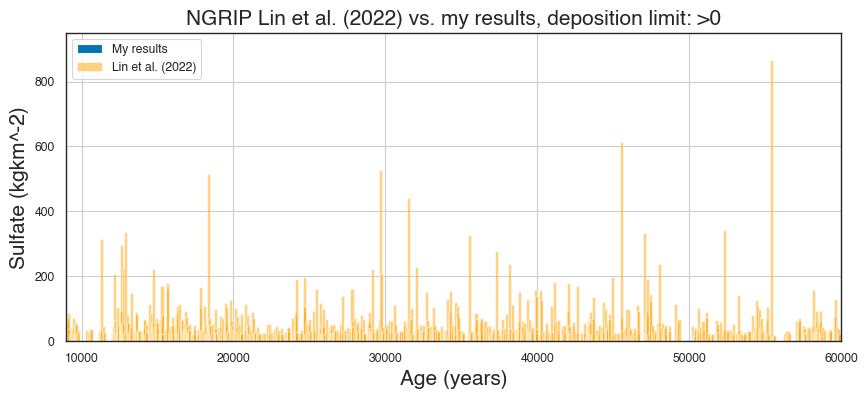

In [29]:
plt.figure(figsize=(10,4))
plt.bar(year_s, sulfate_dep_s, width=200, color='b', alpha=1, label='My results')
plt.bar(NGRIP_jiamei_age_s, NGRIP_jiamei_dep_s, width=200, color='orange', alpha=.5, label='Lin et al. (2022)')
plt.xlabel('Age (years)', fontsize=15)
plt.ylabel('Sulfate (kgkm^-2)', fontsize=15)
plt.xlim(9000,60000)
plt.ylim(0,950)
plt.grid('both')
plt.title('NGRIP Lin et al. (2022) vs. my results, deposition limit: >' + str(limit), fontsize=15)
plt.legend()
plt.savefig('NGRIP_sulfatedep_detlim_' + str(limit), dpi=1000, bbox_inches='tight')
plt.show()

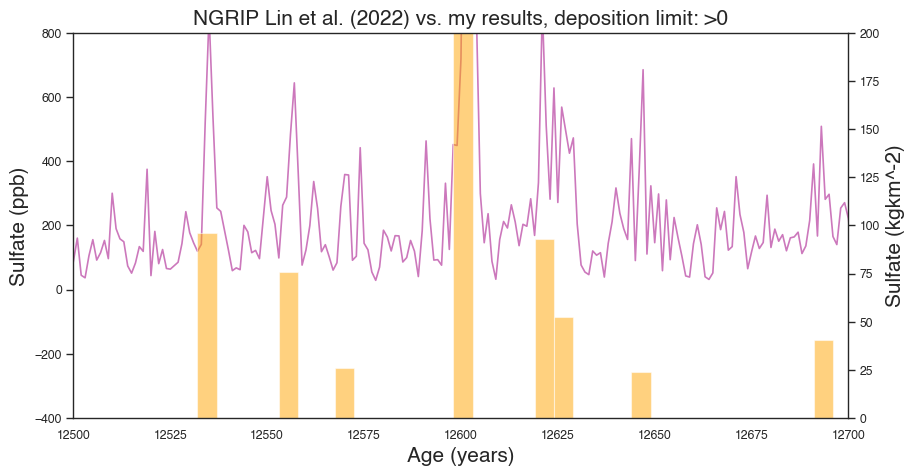

In [30]:
f, ax1 = plt.subplots(1, 1,figsize=(10,5), sharex=True, subplot_kw=dict(frameon=False))
    
ax2 = plt.twinx()

ax1.plot(NGRIP_annual, NGRIP_sulfate_annual, color='m')
ax1.set_ylim(-400,800)
ax2.bar(year_s, sulfate_dep_s, width=5, color='b')
ax2.bar(NGRIP_jiamei_age_s, NGRIP_jiamei_dep_s, width=5, color='orange', alpha=.5)
ax2.set_ylim(0,200)
plt.xlim(12500,12700)
ax1.set_xlabel('Age (years)', fontsize=15)
ax2.set_ylabel('Sulfate (kgkm^-2)', fontsize=15)
ax1.set_ylabel('Sulfate (ppb)', fontsize=15)
plt.title('NGRIP Lin et al. (2022) vs. my results, deposition limit: >' + str(limit), fontsize=15)
plt.savefig('NGRIP_sulfateppb_detlim_' + str(limit), dpi=1000, bbox_inches='tight')
plt.show()